In [1]:
from functions import *

2024-12-10 15:12:08.935332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 15:12:08.955841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 15:12:08.962173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 15:12:08.978426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 15:12:10.091994: W tensorflow/compiler/tf2

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm
from rasterio.windows import Window
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Load data

#### Load raw data paths

In [6]:
W = 128
source_path = '../data/raw/'
data_paths = ['lst','ndvi']#,'slope','direction','altitude']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k: [] for k in data_paths}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            if not files and not dirs:
                os.rmdir(subdir)
            else:
                all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths

{'lst': ['../data/raw/lst/cell_67',
  '../data/raw/lst/cell_2',
  '../data/raw/lst/cell_70',
  '../data/raw/lst/cell_31',
  '../data/raw/lst/cell_19',
  '../data/raw/lst/cell_29',
  '../data/raw/lst/cell_71',
  '../data/raw/lst/cell_49',
  '../data/raw/lst/cell_43',
  '../data/raw/lst/cell_10',
  '../data/raw/lst/cell_13',
  '../data/raw/lst/cell_41',
  '../data/raw/lst/cell_21',
  '../data/raw/lst/cell_11',
  '../data/raw/lst/cell_58',
  '../data/raw/lst/cell_56',
  '../data/raw/lst/cell_74',
  '../data/raw/lst/cell_37',
  '../data/raw/lst/cell_62',
  '../data/raw/lst/cell_72',
  '../data/raw/lst/cell_65',
  '../data/raw/lst/cell_8',
  '../data/raw/lst/cell_80',
  '../data/raw/lst/cell_68',
  '../data/raw/lst/cell_9',
  '../data/raw/lst/cell_18',
  '../data/raw/lst/cell_69',
  '../data/raw/lst/cell_3',
  '../data/raw/lst/cell_46',
  '../data/raw/lst/cell_23',
  '../data/raw/lst/cell_28',
  '../data/raw/lst/cell_33',
  '../data/raw/lst/cell_54',
  '../data/raw/lst/cell_76',
  '../data/

In [7]:
source_folder='../data/external/shp/river_cells_oficial'
rivers = get_rivers_altitude(source_folder,False)[0]

In [8]:
source_path = '../data/preprocessed/'
data_paths = ['slope','direction','altitude']
dir_paths = [os.path.join(source_path, p) for p in data_paths]
for i, dir_p in enumerate(dir_paths):
    for subdir, dirs, files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif dir_p.endswith('altitude'):
            all_dir_paths[data_paths[i]].extend([f for f in files if f.split('.')[0] in rivers])
all_dir_paths    

KeyError: 'slope'

In [9]:
dir_path = '../data/raw/wt'
water_temp = pd.read_csv(f'{dir_path}/water_temp.csv', index_col=0)
water_temp

1      2     3      4      5      6      7      8  \
Zeitstempel                                                                  
2013-03-01 00:00:00   5.76   1.05  2.72   2.91   3.61   5.86   3.23   7.46   
2013-04-01 00:00:00   8.16   3.23  3.62   5.43   5.91   8.54   5.20   8.94   
2013-05-01 00:00:00  12.06   5.38  4.49   6.83   8.68  12.21   8.49   9.46   
2013-06-01 00:00:00  15.15   9.05  5.01   8.56  12.00  15.21  12.85  10.42   
2013-07-01 00:00:00  19.52  12.63  6.34  10.80  15.42  21.28  17.35  11.98   
...                    ...    ...   ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  13.94   6.03  4.81   7.26  10.67  13.85  11.10  10.58   
2024-06-01 00:00:00  16.58   9.45  5.38   8.63  13.05  17.00  13.57  11.62   
2024-07-01 00:00:00  19.75  12.10  6.82  10.47  15.52  20.68  16.94  12.39   
2024-08-01 00:00:00  21.82  14.09  7.55  12.48  16.50  23.24  18.44  13.35   
2024-09-01 00:00:00  18.45  10.32  5.91   9.56  12.78  19.08  13.64  11.79   

                         9     10  ...     72     73     74     75     76  \
Zeitstempel                        ...                                      
2013-03-01 00:00:00   6.24   5.59  ...   5.96   8.20   4.04   6.69   6.04   
2013-04-01 00:00:00   8.94   8.33  ...   8.02   9.92   5.92   9.93   8.77   
2013-05-01 00:00:00  10.16  11.65  ...   8.53  10.93   6.86  13.71  10.15   
2013-06-01 00:00:00  13.67  15.12  ...  10.90  12.93   8.49  17.17  14.04   
2013-07-01 00:00:00  19.61  20.50  ...  13.75  16.97  10.80  20.67  20.99   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  12.20  13.40  ...  10.36  12.10   7.63  15.62  12.29   
2024-06-01 00:00:00  15.24  16.79  ...  12.24  13.55   9.03  18.39  15.95   
2024-07-01 00:00:00  18.90  20.38  ...  14.30  15.95  10.74  20.82  19.92   
2024-08-01 00:00:00  22.41  22.75  ...  16.34  17.93  11.85  21.27  23.87   
2024-09-01 00:00:00  16.21  18.08  ...  12.46  14.41   9.55  17.76  16.90   

                        77     78     79     80      81  
Zeitstempel                                              
2013-03-01 00:00:00   6.06   5.48   3.83   4.64    0.96  
2013-04-01 00:00:00   8.77   8.22   8.19   8.90    1.56  
2013-05-01 00:00:00  12.35  10.14  10.75  11.26    1.31  
2013-06-01 00:00:00  15.36  13.41  13.63  15.18    1.31  
2013-07-01 00:00:00  21.30  17.45  17.22  20.13    1.25  
...                    ...    ...    ...    ...     ...  
2024-05-01 00:00:00  13.95  11.97  12.41  14.02    1.79  
2024-06-01 00:00:00  17.04  14.46  14.65  16.51    1.56  
2024-07-01 00:00:00  20.67  17.49  17.22  19.97   Lücke  
2024-08-01 00:00:00  23.25  18.12  18.68  21.36  223.36  
2024-09-01 00:00:00  19.28  14.64  15.01  15.49    0.19  

[139 rows x 81 columns]

In [10]:
water_temp.index = pd.to_datetime(water_temp.index).strftime('%Y-%m')

In [11]:
dir_path = '../data/raw/disch'
discharge = pd.read_csv(f'{dir_path}/discharge.csv', index_col=0)
discharge

1        2      3       4         5   6        7  \
Zeitstempel                                                                  
2013-03-01 00:00:00   3.834  241.330  0.370   7.524   789.141 NaN   61.336   
2013-04-01 00:00:00  13.225  494.202  1.263  25.170  1242.046 NaN  146.108   
2013-05-01 00:00:00  34.581  481.324  2.839  39.725  1534.415 NaN  203.023   
2013-06-01 00:00:00  49.038  555.743  4.844  53.951  2078.567 NaN  263.358   
2013-07-01 00:00:00  49.649  328.907  3.820  28.298  1278.919 NaN  188.776   
...                     ...      ...    ...     ...       ...  ..      ...   
2024-05-01 00:00:00  40.826  414.496  3.753  38.421  1409.133 NaN  206.337   
2024-06-01 00:00:00  74.990  529.848  6.792  56.341  2234.300 NaN  289.505   
2024-07-01 00:00:00  66.826  412.620  4.972  27.925  1706.039 NaN  263.186   
2024-08-01 00:00:00  30.392  305.790  1.691  11.206  1012.719 NaN  208.326   
2024-09-01 00:00:00  21.467  333.607  1.501  19.832   962.979 NaN  165.468   

                          8      9       10  ...       67       68      69  \
Zeitstempel                                  ...                             
2013-03-01 00:00:00  10.462  2.540  278.162  ...   77.258  251.300  10.027   
2013-04-01 00:00:00  14.393  5.024  320.034  ...  104.718  412.565  10.138   
2013-05-01 00:00:00  10.223  5.075  521.190  ...  161.314  496.318  12.847   
2013-06-01 00:00:00   8.535  8.664  779.648  ...  220.030  547.048  22.801   
2013-07-01 00:00:00   3.332  2.165  555.155  ...  119.553  498.051  10.907   
...                     ...    ...      ...  ...      ...      ...     ...   
2024-05-01 00:00:00   6.453  5.990  498.208  ...  133.785  382.467  13.655   
2024-06-01 00:00:00   7.493  9.641  893.374  ...  233.992  610.775  19.860   
2024-07-01 00:00:00   4.156  6.010  789.944  ...  150.107  662.264  13.512   
2024-08-01 00:00:00   2.162  1.621  431.492  ...   68.495  478.604   9.515   
2024-09-01 00:00:00   6.632  3.873  314.758  ...   84.378  397.724  12.165   

                        70       71       72        73       74      75  \
Zeitstempel                                                               
2013-03-01 00:00:00  1.997  159.477  101.443   387.390  105.679  12.149   
2013-04-01 00:00:00  1.775  366.584  141.716   732.260  226.698  27.070   
2013-05-01 00:00:00  1.947  378.951  250.523   868.901  291.301  22.402   
2013-06-01 00:00:00  4.798  435.299  337.491  1120.716  339.567  25.792   
2013-07-01 00:00:00  0.708  266.880  337.819   644.033  224.320   7.271   
...                    ...      ...      ...       ...      ...     ...   
2024-05-01 00:00:00  1.995  324.285  260.007   769.702  237.402  21.262   
2024-06-01 00:00:00  3.494  412.651  457.059  1151.792  336.151  22.075   
2024-07-01 00:00:00  1.393  336.097  475.067   820.925  284.955  15.027   
2024-08-01 00:00:00  0.426  254.383  394.565   520.790  221.783   8.580   
2024-09-01 00:00:00  0.457  266.322  246.177   558.287  201.420  14.609   

                          76  
Zeitstempel                   
2013-03-01 00:00:00   79.588  
2013-04-01 00:00:00  149.656  
2013-05-01 00:00:00  237.434  
2013-06-01 00:00:00  332.866  
2013-07-01 00:00:00  203.237  
...                      ...  
2024-05-01 00:00:00  211.573  
2024-06-01 00:00:00  341.667  
2024-07-01 00:00:00  244.022  
2024-08-01 00:00:00  141.286  
2024-09-01 00:00:00  140.717  

[139 rows x 76 columns]

In [12]:
discharge.index = pd.to_datetime(discharge.index).strftime('%Y-%m')

#### Load images and times

In [13]:
t=[]
total_data = {}
total_times = {}

In [14]:
# Load input data
time_split=False
save_labels = []
for k,v in all_dir_paths.items():
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        print('Doing',k)
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
    
        labels = []
        for ki,value in data.items():
            labels+=[ki.split('/')[-1]]*len(value)

        if labels != []:
            save_labels = labels
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
        
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

Doing lst
lst : (11259, 128, 128, 3)
Doing ndvi


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


ndvi : (11259, 128, 128)


In [ ]:
for k, v in all_dir_paths.items():
    if k in ['direction', 'slope', 'altitude']:
        imgss = {}
        total = []
        for i, lab in enumerate(save_labels):
            for file in v:
                print(file)
                if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                    if lab not in imgss:
                        file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join(f'../data/preprocessed/altitude', file)
                        r, m = load_raster(file_path, False)
                        var = resize_image(r, W, W)
                        var = np.where(np.isnan(var), 0.0, var)
                        imgss[lab] = var
                    else:
                        var = imgss[lab]
            total.append(var)

        total_data[k] = np.array(total)
        print(f"{k}: {np.array(total).shape}")


In [15]:
total_data.keys()

dict_keys(['lst', 'ndvi'])

In [16]:
total_cells = []
for v in all_dir_paths['lst']:
    cell = v.split('/')[-1]
    total_cells.extend([cell]*len(times[0]))

In [17]:
lst = total_data['lst']
ndvi = total_data['ndvi']
#data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
#print('targets shape:', data_targets.shape)

inputs shape: (11259, 128, 128, 3) (11259, 128, 128)


In [18]:
time_slots = np.array(total_times['lst'])
time_slots

array(['2013-03', '2013-04', '2013-05', ..., '2024-07', '2024-08',
       '2024-09'], dtype='<U7')

In [19]:
len(time_slots)

11259

In [20]:
for k,v in total_data.items():
    print(k,v.shape)

lst (11259, 128, 128, 3)
ndvi (11259, 128, 128)


#### Load rivers

In [24]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


## Data Descriptive Analysis

In [ ]:
discharge.shape

In [20]:
for i in range(74, 82):
    discharge[f"{i}"] = np.nan
discharge

1        2      3       4         5   6        7       8  \
Zeitstempel                                                                  
2013-03       3.834  241.330  0.370   7.524   789.141 NaN   61.336  10.462   
2013-04      13.225  494.202  1.263  25.170  1242.046 NaN  146.108  14.393   
2013-05      34.581  481.324  2.839  39.725  1534.415 NaN  203.023  10.223   
2013-06      49.038  555.743  4.844  53.951  2078.567 NaN  263.358   8.535   
2013-07      49.649  328.907  3.820  28.298  1278.919 NaN  188.776   3.332   
...             ...      ...    ...     ...       ...  ..      ...     ...   
2024-05      40.826  414.496  3.753  38.421  1409.133 NaN  206.337   6.453   
2024-06      74.990  529.848  6.792  56.341  2234.300 NaN  289.505   7.493   
2024-07      66.826  412.620  4.972  27.925  1706.039 NaN  263.186   4.156   
2024-08      30.392  305.790  1.691  11.206  1012.719 NaN  208.326   2.162   
2024-09      21.467  333.607  1.501  19.832   962.979 NaN  165.468   6.632   

                 9       10  ...       72        73  74  75  76  77  78  79  \
Zeitstempel                  ...                                              
2013-03      2.540  278.162  ...  101.443   387.390 NaN NaN NaN NaN NaN NaN   
2013-04      5.024  320.034  ...  141.716   732.260 NaN NaN NaN NaN NaN NaN   
2013-05      5.075  521.190  ...  250.523   868.901 NaN NaN NaN NaN NaN NaN   
2013-06      8.664  779.648  ...  337.491  1120.716 NaN NaN NaN NaN NaN NaN   
2013-07      2.165  555.155  ...  337.819   644.033 NaN NaN NaN NaN NaN NaN   
...            ...      ...  ...      ...       ...  ..  ..  ..  ..  ..  ..   
2024-05      5.990  498.208  ...  260.007   769.702 NaN NaN NaN NaN NaN NaN   
2024-06      9.641  893.374  ...  457.059  1151.792 NaN NaN NaN NaN NaN NaN   
2024-07      6.010  789.944  ...  475.067   820.925 NaN NaN NaN NaN NaN NaN   
2024-08      1.621  431.492  ...  394.565   520.790 NaN NaN NaN NaN NaN NaN   
2024-09      3.873  314.758  ...  246.177   558.287 NaN NaN NaN NaN NaN NaN   

             80  81  
Zeitstempel          
2013-03     NaN NaN  
2013-04     NaN NaN  
2013-05     NaN NaN  
2013-06     NaN NaN  
2013-07     NaN NaN  
...          ..  ..  
2024-05     NaN NaN  
2024-06     NaN NaN  
2024-07     NaN NaN  
2024-08     NaN NaN  
2024-09     NaN NaN  

[139 rows x 81 columns]

In [21]:
# Resumir cada imagen con valores representativos (por ejemplo, la media de todos los píxeles)
data_dict = {
    "LST": [img.mean() for img in total_data['lst'][..., 0]],  # Media de cada imagen de LST
    "NDVI": [img.mean() for img in total_data['ndvi']],            # Media de cada imagen de NDVI
    "Slope (%)": [img.mean() for img in total_data['slope']],      # Media de cada imagen de pendiente
    "Discharge (m³/s)": np.array(discharge).flatten(),             # Descarga (ya aplanada)
    "Slope Direction (°)": [img.mean() for img in total_data['direction']], # Media de dirección de pendiente
    "Water temperature (°C)": np.array(water_temp).flatten(),      # Temperatura del agua (ya aplanada)
    "Date": time_slots,                                            # Fechas
    "Cell ID": save_labels                                              # Identificadores de celdas
}

# Crear el DataFrame
df = pd.DataFrame(data_dict)


In [22]:
# Filtrar columnas numéricas
df["Water temperature (°C)"] = pd.to_numeric(df["Water temperature (°C)"], errors="coerce")

numeric_columns = ['LST', 'NDVI', 'Slope (%)', 'Discharge (m³/s)', 'Slope Direction (°)','Water temperature (°C)']

# Calcular estadísticas descriptivas
descriptive_stats = df[numeric_columns].describe(percentiles=[0.25, 0.5, 0.75]).T
print(descriptive_stats.shape)
# Renombrar columnas para mayor claridad
descriptive_stats.rename(columns={
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "max": "Max"
}, inplace=True)

# Añadir una columna para la descripción de las variables (opcional)
descriptive_stats["Description"] = [
    "Land Surface Temperature",
    "Normalized Difference Vegetation Index",
    "Slope (as a percentage)",
    "Discharge (cubic meters per second)",
    "Slope Direction (degrees)",
    "Water Temperature (celsius degrees)"
]

# Reorganizar columnas para mejorar la presentación
descriptive_stats = descriptive_stats[["Description", "Min", "25th Percentile", "Median", "Mean", "75th Percentile", "Max", "Std Dev"]]

# Mostrar los resultados
descriptive_stats


(6, 8)


Description       Min  \
LST                                   Land Surface Temperature  0.000000   
NDVI                    Normalized Difference Vegetation Index -0.108168   
Slope (%)                              Slope (as a percentage)  0.993555   
Discharge (m³/s)           Discharge (cubic meters per second)  0.013000   
Slope Direction (°)                  Slope Direction (degrees)  3.093519   
Water temperature (°C)     Water Temperature (celsius degrees)  0.020000   

                        25th Percentile      Median        Mean  \
LST                          128.012680  255.000000  188.920675   
NDVI                           0.244060    0.473801    0.411093   
Slope (%)                      1.139117    1.773608    2.634696   
Discharge (m³/s)               1.939500   10.754000   89.538431   
Slope Direction (°)            5.324658   10.880266   12.797163   
Water temperature (°C)         5.860000    8.740000    9.756356   

                        75th Percentile          Max     Std Dev  
LST                          255.000000   255.000000   86.893156  
NDVI                           0.597811     0.758684    0.226631  
Slope (%)                      4.155979     9.851131    1.799590  
Discharge (m³/s)              64.114750  2433.485000  209.375949  
Slope Direction (°)           20.318132    35.051190    7.975335  
Water temperature (°C)        13.362500   223.360000    5.701754

In [23]:
# Convertir el DataFrame a LaTeX
latex_code = descriptive_stats.to_latex(index=True)
print(latex_code)  # Copiar este código a tu documento LaTeX


\begin{tabular}{llrrrrrrr}
\toprule
 & Description & Min & 25th Percentile & Median & Mean & 75th Percentile & Max & Std Dev \\
\midrule
LST & Land Surface Temperature & 0.000000 & 128.012680 & 255.000000 & 188.920675 & 255.000000 & 255.000000 & 86.893156 \\
NDVI & Normalized Difference Vegetation Index & -0.108168 & 0.244060 & 0.473801 & 0.411093 & 0.597811 & 0.758684 & 0.226631 \\
Slope (%) & Slope (as a percentage) & 0.993555 & 1.139117 & 1.773608 & 2.634696 & 4.155979 & 9.851131 & 1.799590 \\
Discharge (m³/s) & Discharge (cubic meters per second) & 0.013000 & 1.939500 & 10.754000 & 89.538431 & 64.114750 & 2433.485000 & 209.375949 \\
Slope Direction (°) & Slope Direction (degrees) & 3.093519 & 5.324658 & 10.880266 & 12.797163 & 20.318132 & 35.051190 & 7.975335 \\
Water temperature (°C) & Water Temperature (celsius degrees) & 0.020000 & 5.860000 & 8.740000 & 9.756356 & 13.362500 & 223.360000 & 5.701754 \\
\bottomrule
\end{tabular}



# Delete unuseful data

In [42]:
del total_data['direction']

KeyError: 'direction'

too much black 67.572021484375


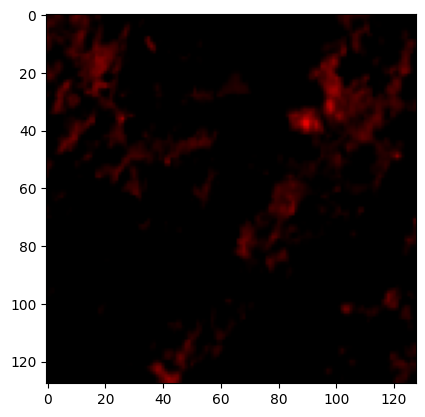

too much black 51.470947265625


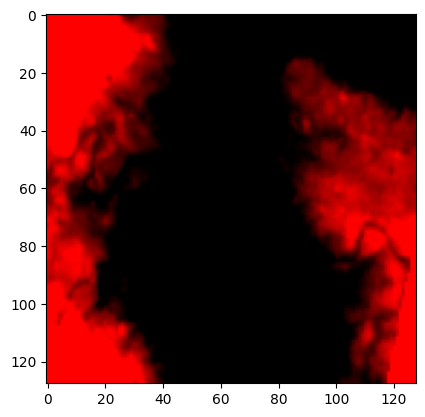

too much black 67.56591796875


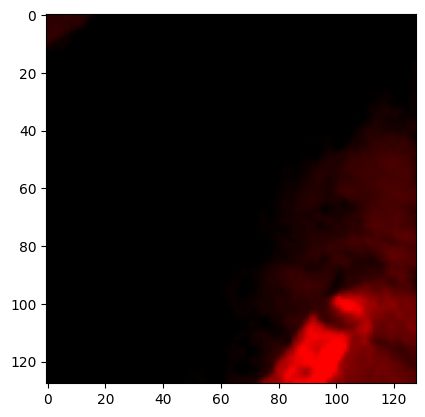

too much black 78.89404296875


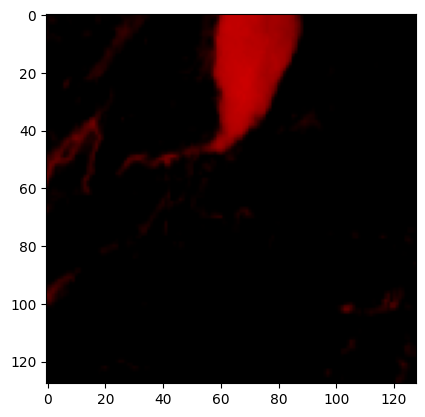

too much black 95.062255859375


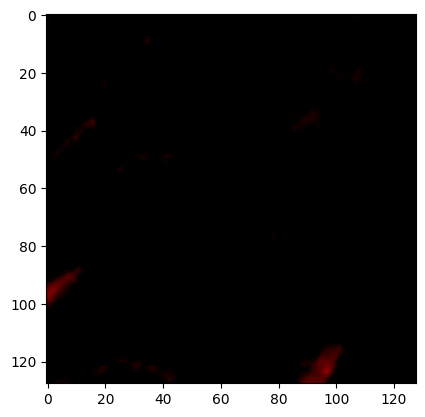

too much black 58.758544921875


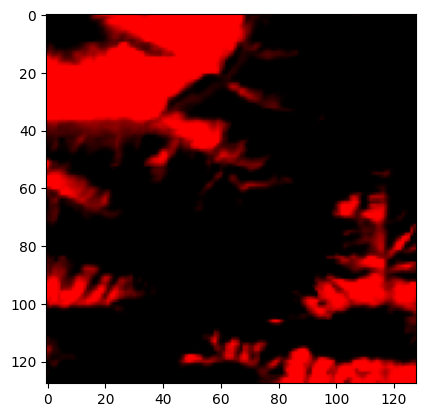

too much black 95.074462890625


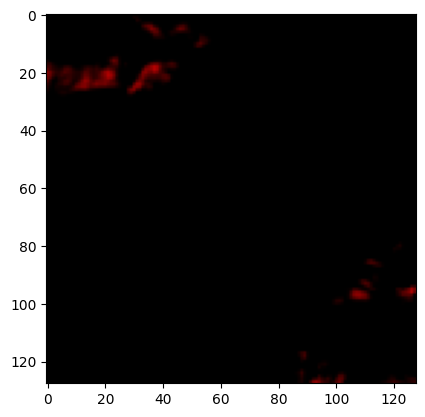

too much black 99.49951171875


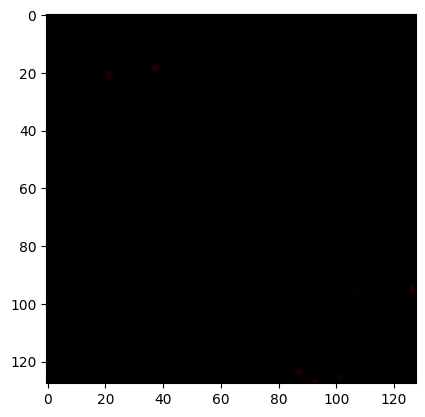

too much black 57.696533203125


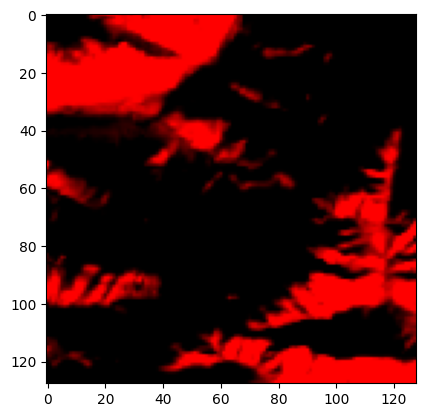

too much black 98.91357421875


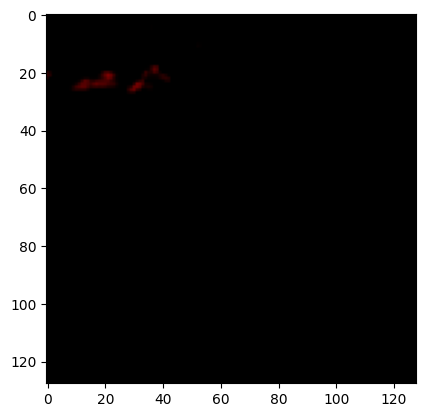

too much white 9.271240234375


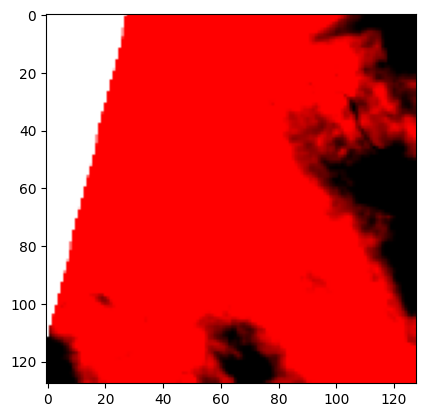

too much white 7.891845703125


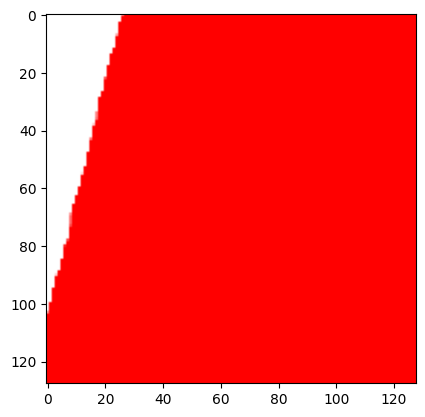

too much white 7.098388671875


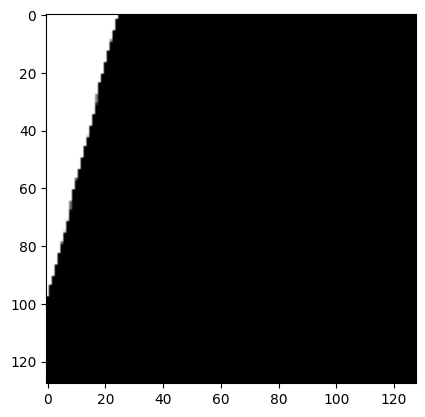

too much white 6.94580078125


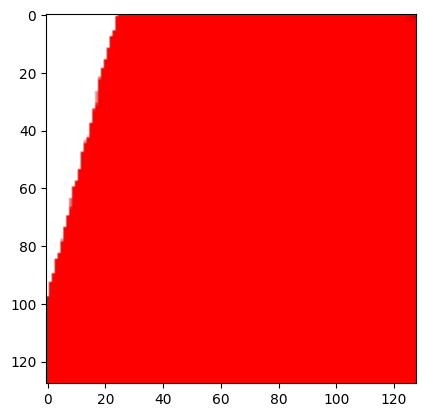

too much white 5.389404296875


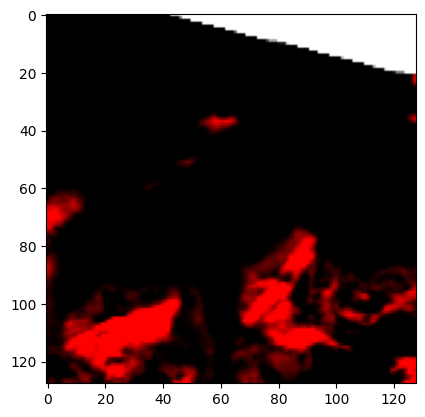

too much white 9.039306640625


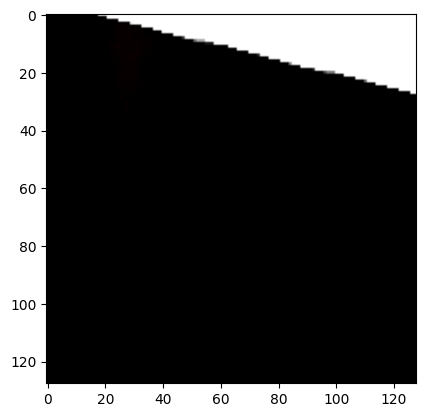

too much white 8.441162109375


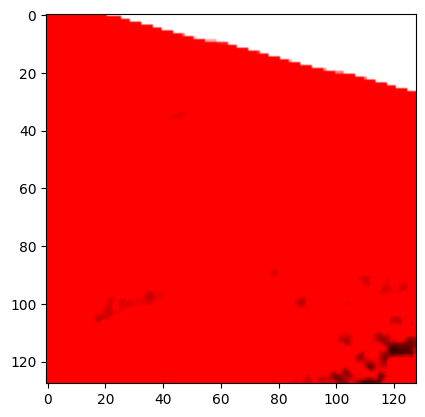

too much white 6.341552734375


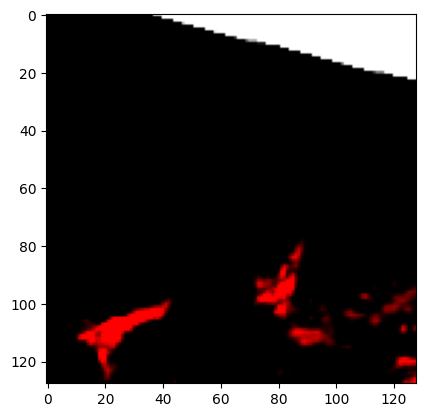

too much white 6.82373046875


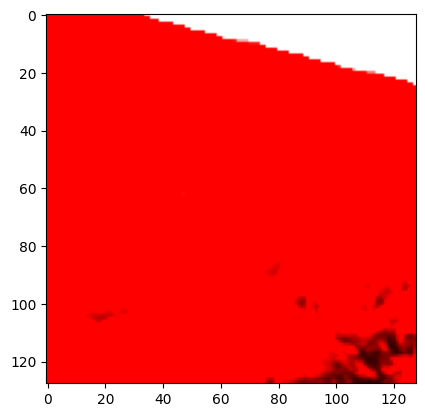

too much white 6.243896484375


In [33]:
def calculate_conditions(img_gray):
    """Calculate conditions for invalid images."""
    if len(total_data[k][index].shape) == 2:
        img_gray = img_gray
    else:
        img_gray = np.dot(img_gray, [0.2989, 0.5870, 0.1140])
        
    blacks = img_gray == 0
    whites = img_gray >= 240
    num_nans = np.sum(np.isnan(img_gray))
    
    percentage_b = np.sum(blacks) / blacks.size * 100
    percentage_w = np.sum(whites) / whites.size * 100
    percentage_nans = (num_nans * 100) / img_gray.size
    
    return {
        "percentage_b": percentage_b,
        "percentage_w": percentage_w,
        "percentage_nans": percentage_nans,
        "is_nan": np.all(np.isnan(img_gray)),
        "is_uniform": np.all(img_gray == img_gray[0, 0]),
    }


del_indices = set()
fixed_ndvi = []
show = 0
showw = 0

for index in range(lst.shape[0]):
    if index in del_indices:
        continue  # Skip already marked indices

    for k in total_data.keys():
        if k not in {'wt', 'slope', 'altitude'}:
            if len(total_data[k][index].shape) == 2:
                img_gray = total_data[k][index]
            else:
                img_gray = total_data[k][index][...,:3]
            
            # Calculate conditions
            cond = calculate_conditions(img_gray)
            conditions = [
                cond["is_uniform"],
                cond["percentage_b"] > 50,
                cond["percentage_w"] > 0,
                cond["is_nan"],
                cond["percentage_nans"] > 50,
            ]

            if any(conditions):
                del_indices.add(index)
                if cond["percentage_b"] > 50 and show < 10:
                    print('too much black',cond["percentage_b"])
                    show_im =np.clip(total_data[k][index]*(6/255),0,1)
                    plt.imshow(show_im)
                    plt.show()
                    show += 1
                elif 5 < cond["percentage_w"] < 10 and showw < 10:
                    print('too much white',cond["percentage_w"])
                    show_im =np.clip(total_data[k][index]*(6/255),0,1)
                    plt.imshow(show_im)
                    plt.show()
                    showw += 1
                break

            # Fix NDVI if applicable
            if k == 'ndvi':
                new_ndvi = np.where(np.isnan(total_data[k][index]), 0.0, total_data[k][index])
                fixed_ndvi.append(new_ndvi)


In [34]:
fixed_ndvi = np.array(fixed_ndvi)

In [35]:
slots = np.delete(time_slots,list(del_indices))

In [36]:
len(slots)

1461

In [37]:
clean_cells = np.delete(np.array(save_labels),list(del_indices))
len(clean_cells)

1461

In [38]:
len(fixed_ndvi)

1461

### Clean water temperature data

In [39]:
wt_values = pd.DataFrame(columns=["Cell", "Date", "WaterTemp"])
del_cells={}
for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    temp_value = water_temp.loc[keep_date][keep_cell.split('_')[-1]]

    # Comprobar si temp_value no es 'Lücke' y es un número válido
    if temp_value != 'Lücke' and isinstance(temp_value, (int, float)) and not np.isnan(temp_value):
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [temp_value]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    elif isinstance(temp_value, str) and temp_value.replace('.', '', 1).isdigit():
        # Convertir temp_value a float si es una cadena numérica
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [float(temp_value)]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    else:
        # Si el valor no es numérico o es 'Lücke', añadirlo a del_cells
        if keep_cell not in del_cells:
            del_cells[keep_cell] = [keep_date]
        else:
            del_cells[keep_cell].append(keep_date)
        print('hola', temp_value, keep_cell, keep_date)

del_cells

/tmp/ipykernel_933313/1651386172.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wt_values = pd.concat([wt_values, new_row], ignore_index=True)


hola nan cell_70 2013-12
hola nan cell_70 2014-03
hola nan cell_70 2014-04
hola nan cell_70 2014-08
hola nan cell_70 2015-08
hola nan cell_70 2017-06
hola nan cell_70 2017-10
hola nan cell_70 2017-11
hola nan cell_70 2017-12
hola nan cell_70 2018-04
hola nan cell_70 2018-06
hola nan cell_70 2018-08
hola nan cell_70 2019-01
hola nan cell_70 2019-09
hola nan cell_70 2020-05
hola nan cell_70 2021-01
hola nan cell_70 2021-06
hola nan cell_70 2021-09
hola nan cell_70 2021-10
hola nan cell_70 2022-02
hola nan cell_70 2022-08
hola nan cell_70 2023-02
hola nan cell_70 2023-03
hola nan cell_70 2024-02
hola Lücke cell_81 2024-07


{'cell_70': ['2013-12',
  '2014-03',
  '2014-04',
  '2014-08',
  '2015-08',
  '2017-06',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-09',
  '2020-05',
  '2021-01',
  '2021-06',
  '2021-09',
  '2021-10',
  '2022-02',
  '2022-08',
  '2023-02',
  '2023-03',
  '2024-02'],
 'cell_81': ['2024-07']}

In [40]:
wt_values

Cell     Date  WaterTemp
0     cell_67  2013-08      12.22
1     cell_67  2014-02       5.91
2     cell_67  2015-05      10.48
3     cell_67  2018-06      11.84
4     cell_67  2020-03       7.41
...       ...      ...        ...
1431  cell_24  2017-06      13.46
1432  cell_24  2021-04       5.86
1433  cell_24  2021-05       7.81
1434  cell_24  2021-12       3.20
1435  cell_24  2024-09      12.00

[1436 rows x 3 columns]

In [41]:
disch_values = pd.DataFrame(columns=["Cell", "Date", "Discharge"])
for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    if keep_cell.split('_')[-1] in discharge.columns:
        temp_value = discharge.loc[keep_date][keep_cell.split('_')[-1]]
    
        # Comprobar si temp_value no es 'Lücke' y es un número válido
        if temp_value != 'Lücke' and isinstance(temp_value, (int, float)) and not np.isnan(temp_value):
            new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "Discharge": [temp_value]})
            disch_values = pd.concat([disch_values, new_row], ignore_index=True)
        elif isinstance(temp_value, str) and temp_value.replace('.', '', 1).isdigit():
            # Convertir temp_value a float si es una cadena numérica
            new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "Discharge": [float(temp_value)]})
            disch_values = pd.concat([disch_values, new_row], ignore_index=True)
        else:
            # Si el valor no es numérico o es 'Lücke', añadirlo a del_cells
            if keep_cell not in del_cells:
                del_cells[keep_cell] = [keep_date]
            else:
                del_cells[keep_cell].append(keep_date)
            print('hola', temp_value, keep_cell, keep_date)
    else:
        if keep_cell not in del_cells:
            del_cells[keep_cell] = [keep_date]
        else:
            del_cells[keep_cell].append(keep_date)
            print('hola', temp_value, keep_cell, keep_date)

del_cells

/tmp/ipykernel_933313/3665125623.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  disch_values = pd.concat([disch_values, new_row], ignore_index=True)


hola 24.492 cell_80 2013-05
hola 24.492 cell_80 2013-07
hola 24.492 cell_80 2014-04
hola 24.492 cell_80 2014-06
hola 24.492 cell_80 2014-07
hola 24.492 cell_80 2014-11
hola 24.492 cell_80 2015-02
hola 24.492 cell_80 2015-03
hola 24.492 cell_80 2015-04
hola 24.492 cell_80 2015-05
hola 24.492 cell_80 2015-08
hola 24.492 cell_80 2016-10
hola 24.492 cell_80 2016-11
hola 24.492 cell_80 2017-11
hola 24.492 cell_80 2017-12
hola 24.492 cell_80 2018-04
hola 24.492 cell_80 2018-05
hola 24.492 cell_80 2018-06
hola 24.492 cell_80 2018-08
hola 24.492 cell_80 2019-01
hola 24.492 cell_80 2019-04
hola 24.492 cell_80 2019-09
hola 24.492 cell_80 2019-11
hola 24.492 cell_80 2020-02
hola 24.492 cell_80 2020-04
hola 24.492 cell_80 2020-06
hola 24.492 cell_80 2020-07
hola 24.492 cell_80 2021-04
hola 24.492 cell_80 2021-05
hola 24.492 cell_80 2021-06
hola 24.492 cell_80 2021-07
hola 24.492 cell_80 2021-09
hola 24.492 cell_80 2021-11
hola 24.492 cell_80 2022-04
hola 24.492 cell_80 2022-06
hola 24.492 cell_80 

{'cell_70': ['2013-12',
  '2014-03',
  '2014-04',
  '2014-08',
  '2015-08',
  '2017-06',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-09',
  '2020-05',
  '2021-01',
  '2021-06',
  '2021-09',
  '2021-10',
  '2022-02',
  '2022-08',
  '2023-02',
  '2023-03',
  '2024-02'],
 'cell_81': ['2024-07',
  '2013-07',
  '2014-05',
  '2014-06',
  '2014-07',
  '2015-01',
  '2015-03',
  '2015-06',
  '2015-08',
  '2015-10',
  '2016-09',
  '2016-11',
  '2017-02',
  '2017-08',
  '2018-02',
  '2019-07',
  '2020-08',
  '2021-01',
  '2022-04',
  '2022-09',
  '2023-04',
  '2023-05',
  '2023-12',
  '2024-07',
  '2024-09'],
 'cell_80': ['2013-03',
  '2013-05',
  '2013-07',
  '2014-04',
  '2014-06',
  '2014-07',
  '2014-11',
  '2015-02',
  '2015-03',
  '2015-04',
  '2015-05',
  '2015-08',
  '2016-10',
  '2016-11',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-05',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-04',
  '2019-09',
  '2019-11',
  '2020-02',
  '

# Download preprocessed data

#### Clean preprocessed directories

In [42]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
    dest_dir = os.path.join(preprocessed_data_path, d)
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)


In [43]:
os.makedirs(f'{preprocessed_data_path}wt',exist_ok=True)
wt_values.to_csv(f'{preprocessed_data_path}wt/water_temp.csv')

In [44]:
os.makedirs(f'{preprocessed_data_path}discharge',exist_ok=True)
disch_values.to_csv(f'{preprocessed_data_path}discharge/discharge.csv')

#### Copy preprocessed images

In [45]:
import rasterio
from rasterio.transform import from_origin, from_bounds
import numpy as np

def save_raster(raster_array, filepath, shp, resolution=30, nodata_value=0.0):
    
    resolution = 30
    x_min, y_min, x_max, y_max = shp.total_bounds
    width, height = raster_array.shape[1], raster_array.shape[0]
    resolution_x = (x_max - x_min) / width
    resolution_y = (y_max - y_min) / height

    print(width,height,raster_array.shape[0],raster_array.shape[1])
    
    #transform = from_origin(x_min, y_max, resolution, resolution)
    transform = from_bounds(x_min, y_min, x_max, y_max, width, height)

    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
    ) as dst:
        if len(raster_array.shape) == 3:
            dst.write(raster_array[:, :, 0], 1)  # Red channel
            dst.write(raster_array[:, :, 1], 2)  # Green channel
            dst.write(raster_array[:, :, 2], 3)  # Blue channel
        else:
            dst.write(raster_array, 1)
    print(f"Raster saved to {filepath} with bounds {x_min}, {y_min}, {x_max}, {y_max}, {shp.crs.to_string()}")




In [46]:
del all_dir_paths['slope']
del all_dir_paths['direction']
del all_dir_paths['altitude']

KeyError: 'slope'

In [49]:
from collections import Counter

for d, paths in all_dir_paths.items():
    count = 0
    included = 0
    imgs_per_river = Counter()
    imgs_out=0
    
    for cell_path in paths:
        try:
            source_dir = cell_path
            cell = cell_path.split('/')[-1]
            
            river = river_cells[cell]
            files = os.listdir(source_dir)
            sorted_files = sorted(files, key=extract_year_month_from_filename)

            dest_dir = os.path.join(preprocessed_data_path, f'{d}/{cell}')
            os.makedirs(dest_dir, exist_ok=True)
    
            for file in sorted_files:
                if count not in del_indices:
                    print('Cell',cell)
                    date = file.split('_')[-1].split('.')[0]
                    
                    if cell in del_cells and date in del_cells[cell]:
                            print('Not this one', cell,date)
                            count+=1
                            included+=1
                            continue
                    
                    if d == 'ndvi':
                        name = f'{dest_dir}/ndvi_{date}.tiff'
                        save_raster(fixed_ndvi[included], name, river)
                        print()
                        print(f'Copied: ndvi_{date}, at {dest_dir}')
                        print()
                    
                    else:
                        dst_path = os.path.join(dest_dir, file)
                        src_path = os.path.join(source_dir, file)
                        # Copy the file to the destination folder
                        shutil.copy(src_path, dst_path)
                        print()
                        print(f'Copied: {file}, from {src_path}, to {dst_path}')
                    included+=1
                    imgs_per_river[cell] += 1
                count+=1
                
        except Exception as e:
            print(e)
            imgs_out += len(os.listdir(source_dir))
            rr = river_cells[cell]
            print(cell)
            print()
            print('afegeixo',len(os.listdir(source_dir)), 'imatges no processades')
            count += len(os.listdir(source_dir))
            pass
        
                

Cell cell_67

Copied: image_2013-08.tiff, from ../data/raw/lst/cell_67/image_2013-08.tiff, to ../data/preprocessed/lst/cell_67/image_2013-08.tiff
Cell cell_67

Copied: image_2014-02.tiff, from ../data/raw/lst/cell_67/image_2014-02.tiff, to ../data/preprocessed/lst/cell_67/image_2014-02.tiff
Cell cell_67

Copied: image_2015-05.tiff, from ../data/raw/lst/cell_67/image_2015-05.tiff, to ../data/preprocessed/lst/cell_67/image_2015-05.tiff
Cell cell_67

Copied: image_2018-06.tiff, from ../data/raw/lst/cell_67/image_2018-06.tiff, to ../data/preprocessed/lst/cell_67/image_2018-06.tiff
Cell cell_67

Copied: image_2020-03.tiff, from ../data/raw/lst/cell_67/image_2020-03.tiff, to ../data/preprocessed/lst/cell_67/image_2020-03.tiff
Cell cell_67

Copied: image_2020-06.tiff, from ../data/raw/lst/cell_67/image_2020-06.tiff, to ../data/preprocessed/lst/cell_67/image_2020-06.tiff
Cell cell_67

Copied: image_2021-09.tiff, from ../data/raw/lst/cell_67/image_2021-09.tiff, to ../data/preprocessed/lst/cell_

In [50]:
print('Final preprocessed images:',np.sum(list(imgs_per_river.values())))
print('Dict:',imgs_per_river)
print('Final nº of cells:',len(imgs_per_river))

Final preprocessed images: 1307
Dict: Counter({'cell_63': 36, 'cell_28': 35, 'cell_71': 34, 'cell_38': 34, 'cell_33': 32, 'cell_46': 27, 'cell_73': 27, 'cell_13': 26, 'cell_74': 25, 'cell_23': 25, 'cell_51': 25, 'cell_22': 24, 'cell_12': 24, 'cell_11': 23, 'cell_9': 23, 'cell_16': 23, 'cell_56': 22, 'cell_68': 21, 'cell_76': 21, 'cell_57': 21, 'cell_27': 21, 'cell_29': 20, 'cell_7': 20, 'cell_42': 20, 'cell_40': 20, 'cell_66': 20, 'cell_47': 20, 'cell_39': 20, 'cell_19': 19, 'cell_58': 19, 'cell_18': 19, 'cell_75': 19, 'cell_53': 19, 'cell_55': 19, 'cell_37': 18, 'cell_34': 18, 'cell_4': 18, 'cell_31': 17, 'cell_72': 17, 'cell_65': 17, 'cell_54': 17, 'cell_14': 17, 'cell_52': 17, 'cell_41': 16, 'cell_30': 16, 'cell_2': 15, 'cell_43': 15, 'cell_26': 15, 'cell_21': 14, 'cell_67': 13, 'cell_10': 13, 'cell_20': 13, 'cell_35': 13, 'cell_44': 13, 'cell_25': 13, 'cell_17': 12, 'cell_45': 12, 'cell_61': 12, 'cell_8': 11, 'cell_69': 11, 'cell_48': 11, 'cell_32': 11, 'cell_62': 10, 'cell_59': 10

CHECK

In [51]:
dir_paths = ['../data/preprocessed/lst/cell_73']
W = 128
list_rgb = [True]
data, time_slots_n = load_data(dir_paths,W,list_rgb)

(27, 128, 128, 3)
0


0


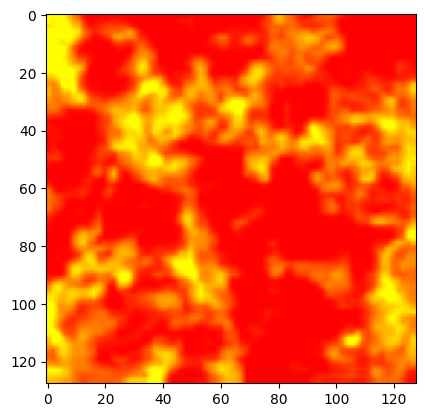

0


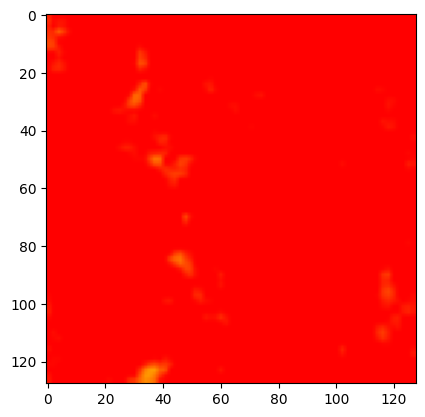

0


0


0


0


0


0


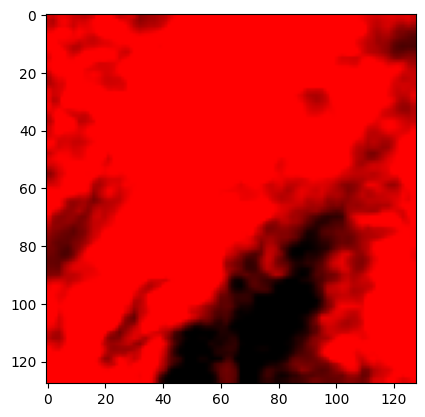

0


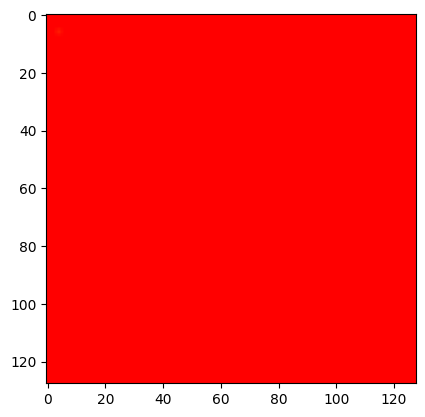

0


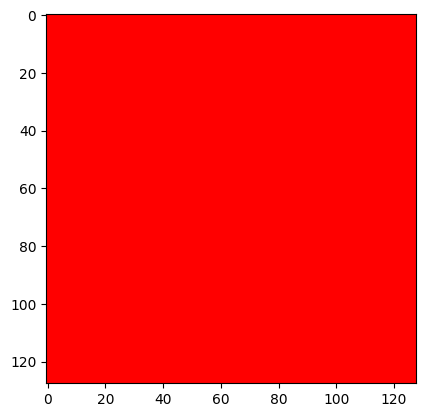

0


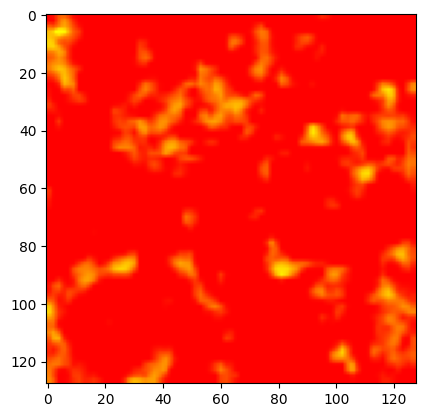

0


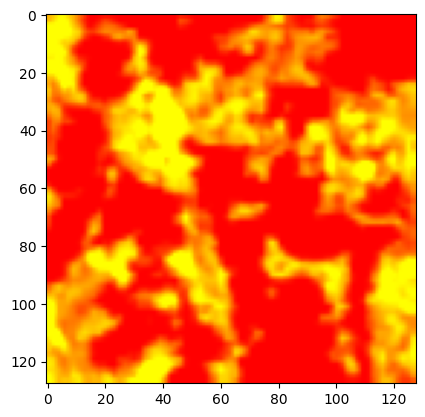

0


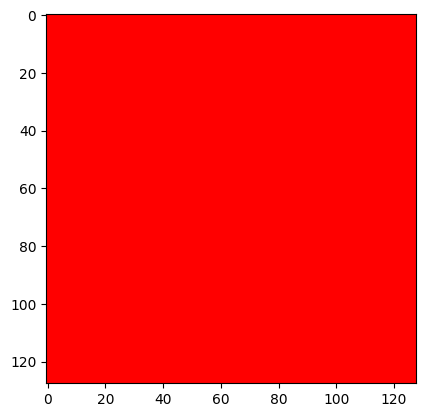

0


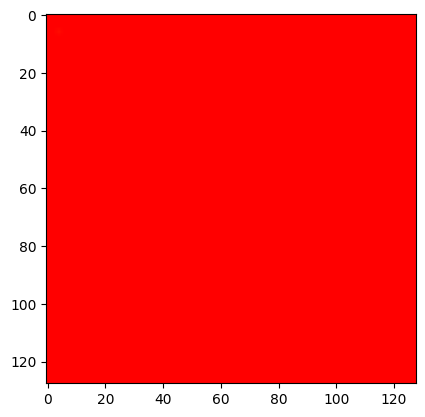

0


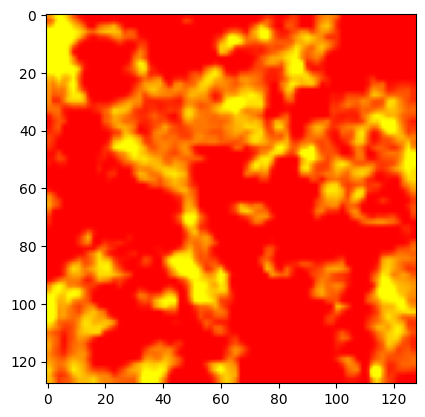

0


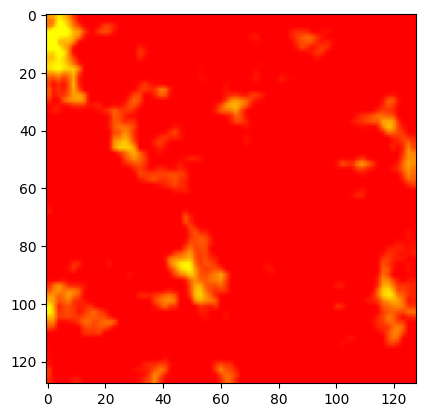

0


0


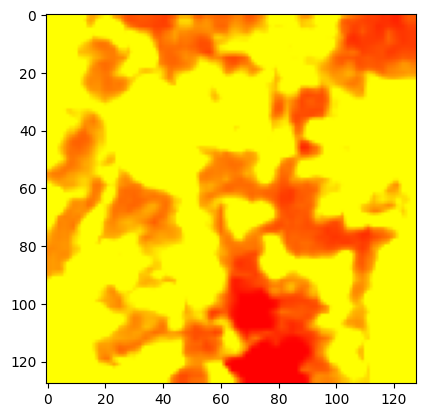

0


0


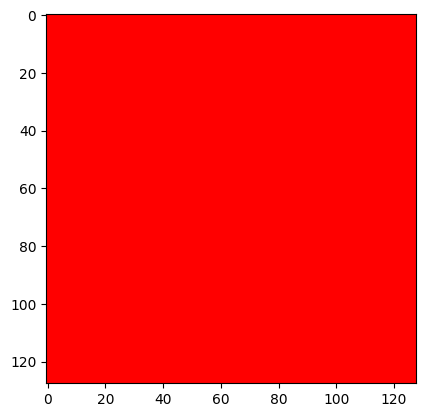

0


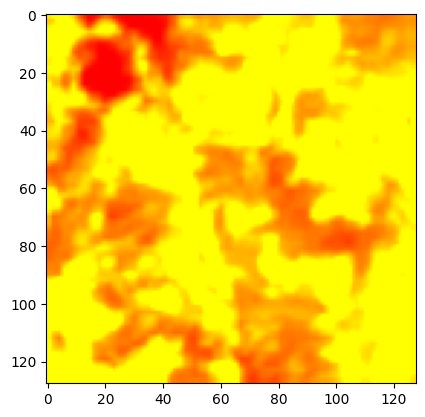

0


0


0


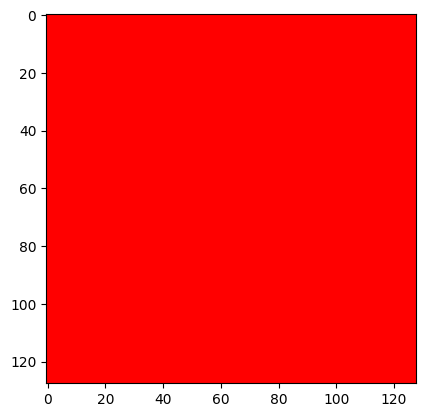

0


0


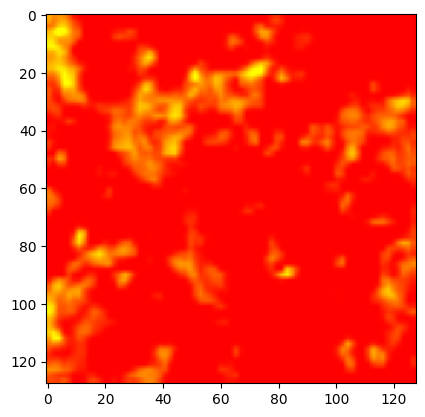

In [52]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(np.clip(i*(6/255),0,1))
  plt.show()

In [3]:
W = 128
source_path = '../data/preprocessed_clean/'
data_paths = ['lst','ndvi']#,'slope','direction','altitude']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k: [] for k in data_paths}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            if not files and not dirs:
                os.rmdir(subdir)
            else:
                all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths

{'lst': ['../data/preprocessed_clean/lst/cell_67',
  '../data/preprocessed_clean/lst/cell_2',
  '../data/preprocessed_clean/lst/cell_31',
  '../data/preprocessed_clean/lst/cell_19',
  '../data/preprocessed_clean/lst/cell_29',
  '../data/preprocessed_clean/lst/cell_71',
  '../data/preprocessed_clean/lst/cell_49',
  '../data/preprocessed_clean/lst/cell_43',
  '../data/preprocessed_clean/lst/cell_10',
  '../data/preprocessed_clean/lst/cell_13',
  '../data/preprocessed_clean/lst/cell_41',
  '../data/preprocessed_clean/lst/cell_21',
  '../data/preprocessed_clean/lst/cell_11',
  '../data/preprocessed_clean/lst/cell_58',
  '../data/preprocessed_clean/lst/cell_56',
  '../data/preprocessed_clean/lst/cell_74',
  '../data/preprocessed_clean/lst/cell_37',
  '../data/preprocessed_clean/lst/cell_62',
  '../data/preprocessed_clean/lst/cell_72',
  '../data/preprocessed_clean/lst/cell_65',
  '../data/preprocessed_clean/lst/cell_8',
  '../data/preprocessed_clean/lst/cell_68',
  '../data/preprocessed_cle

In [4]:
t=[]
total_data = {}
total_times = {}

In [5]:
# Load input data
time_split=False
save_labels = []
for k,v in all_dir_paths.items():
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        print('Doing',k)
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
    
        labels = []
        for ki,value in data.items():
            labels+=[ki.split('/')[-1]]*len(value)

        if labels != []:
            save_labels = labels
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
        
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

Doing lst
lst : (1087, 128, 128, 3)
Doing ndvi
ndvi : (1087, 128, 128)


# Cut images

In [39]:
import rasterio
from rasterio.enums import Resampling

def resize_raster(input_path, output_path, target_width, target_height):
    with rasterio.open(input_path) as src:
        data = src.read(
            out_shape=(
                src.count,
                target_height,
                target_width
            ),
            resampling=Resampling.bilinear
        )
        transform = src.transform * src.transform.scale(
            src.width / target_width,
            src.height / target_height
        )
        profile = src.profile
        profile.update({
            'width': target_width,
            'height': target_height,
            'transform': transform
        })
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)



In [40]:
def crop_rasters_with_metadata(input_paths, output_paths, crop_size):
    """
    Crops each raster file to the central crop_size x crop_size pixel area and updates metadata to reflect new bounds.
    
    Parameters:
    input_paths (list of str): List of file paths to the input rasters.
    output_paths (list of str): List of file paths for saving cropped rasters.
    crop_size (int): Size of the central square to crop (e.g., 8 for 8x8 pixels).
    """

    for i, (input_path, output_path) in enumerate(zip(input_paths, output_paths)):
        #print('Come from', input_path)
        #print('I go to', output_path)
        resize_raster(input_path, input_path, 128, 128)

        with rasterio.open(input_path) as src:
            if crop_size > src.width or crop_size > src.height:
                raise ValueError(f"Crop size {crop_size}x{crop_size} exceeds raster dimensions {src.width}x{src.height}")
            
            # Define the crop window for the central crop_size x crop_size pixels
            left = (src.width - crop_size) // 2
            top = (src.height - crop_size) // 2
            window = Window(left, top, crop_size, crop_size)
            
            # Read the cropped window data
            cropped_data = src.read(window=window)
            
            # Update profile and adjust the transform to reflect the new bounds
            profile = src.profile
            profile.update({
                'width': crop_size,
                'height': crop_size,
                'transform': rasterio.windows.transform(window, src.transform)
            })
            
            # Write the cropped raster with updated metadata
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(cropped_data)
            


In [4]:
inputs = ['lst','ndvi', 'slope', 'altitude', 'direction']
split = 'random'
W = 128

data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

total_data, total_times, data_targets, labels = data

lst : (1307, 128, 128, 3)
ndvi : (1307, 128, 128)
../data/preprocessed/ ole
slope: (1307, 128, 128)
altitude: (1307, 128, 128)
direction: (1307, 128, 128)


In [5]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
river_metas = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks[cc]=rast
    river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
    river_mask_expanded = np.repeat(river_mask_expanded, total_data['lst'].shape[-1], axis=-1)  # Expande a (height, width, 3)
    river_masks_expanded[cc] = river_mask_expanded
    river_metas[cc]=meta

In [41]:
for variable in ["slope", "direction", "lst", "ndvi"]:
    for file in os.listdir(f"{source}{variable}"):
        if variable == 'slope' or variable=='direction':
            with rasterio.open(f"{source}{variable}/{file}/{file}.tif") as src:
                print(f"{variable} - {file}: {src.width}x{src.height}")
        else:
            try:
                img = os.listdir(f"{source}{variable}/{file}")[0]
                with rasterio.open(os.path.join(f"{source}{variable}/{file}",img)) as src:
                    print(f"{variable} - {file}: {src.width}x{src.height}")
            except:
                pass
            

slope - cell_67: 463x379
slope - cell_2: 434x465
slope - cell_70: 465x465
slope - cell_31: 466x466
slope - cell_19: 465x465
slope - cell_29: 465x465
slope - cell_71: 465x465
slope - cell_49: 406x465
slope - cell_43: 465x465
slope - cell_10: 465x465
slope - cell_13: 465x465
slope - cell_41: 465x465
slope - cell_21: 465x465
slope - cell_11: 465x465
slope - cell_58: 465x465
slope - cell_56: 466x466
slope - cell_74: 465x465
slope - cell_37: 464x464
slope - cell_62: 465x465
slope - cell_72: 452x464
slope - cell_65: 465x465
slope - cell_8: 395x466
slope - cell_80: 464x464
slope - cell_68: 465x465
slope - cell_9: 272x322
slope - cell_18: 466x466
slope - cell_69: 314x466
slope - cell_3: 465x465
slope - cell_46: 465x465
slope - cell_23: 465x465
slope - cell_28: 464x464
slope - cell_33: 465x465
slope - cell_54: 465x465
slope - cell_76: 463x463
slope - cell_20: 465x465
slope - cell_22: 465x465
slope - cell_59: 465x465
slope - cell_38: 464x464
slope - cell_7: 465x465
slope - cell_75: 465x465
slope


Fent 8
Faig ../data/preprocessed/8x8/lst


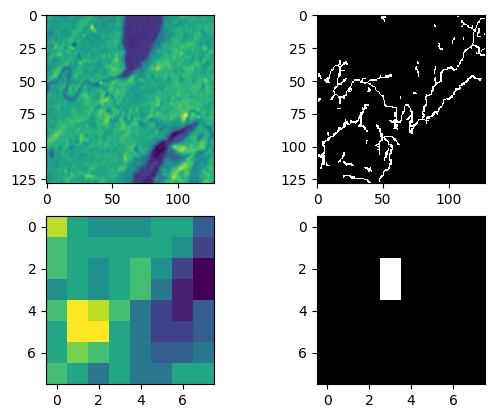

Faig ../data/preprocessed/8x8/ndvi


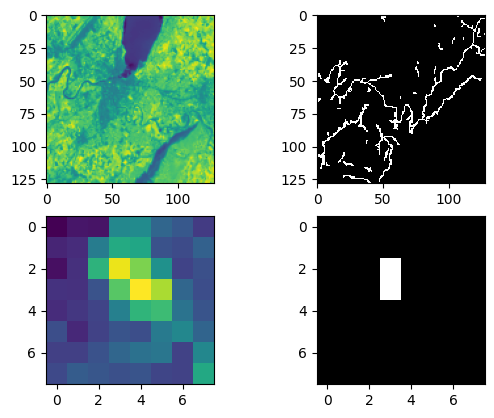

Faig ../data/preprocessed/8x8/slope


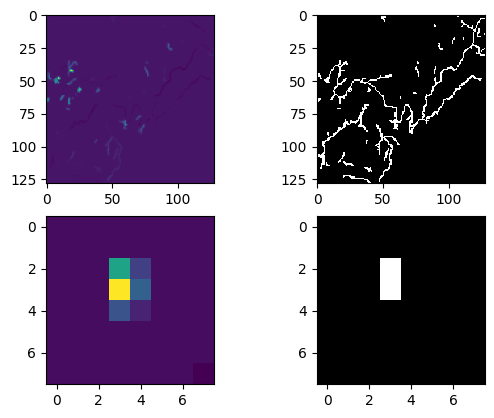

Faig ../data/preprocessed/8x8/altitude


Faig ../data/preprocessed/8x8/direction


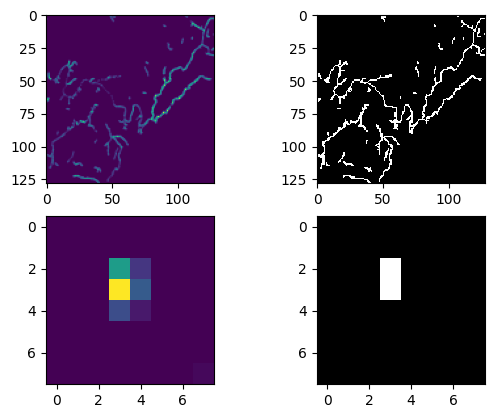


Fent 16
Faig ../data/preprocessed/16x16/lst


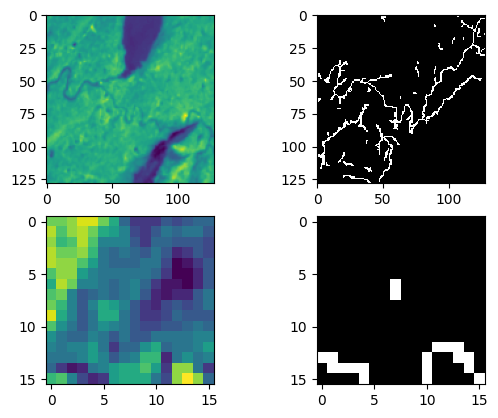

Faig ../data/preprocessed/16x16/ndvi


Faig ../data/preprocessed/16x16/slope


Faig ../data/preprocessed/16x16/altitude


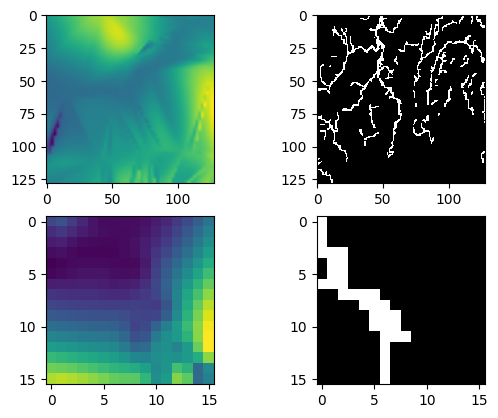

Faig ../data/preprocessed/16x16/direction


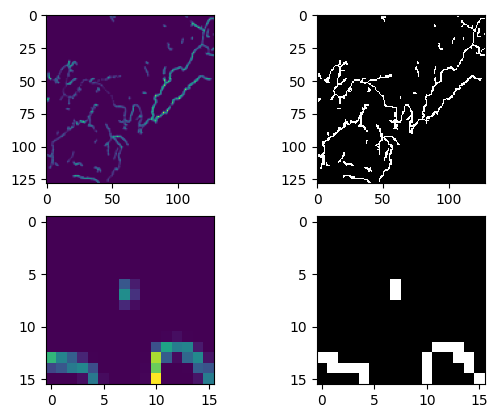


Fent 32
Faig ../data/preprocessed/32x32/lst


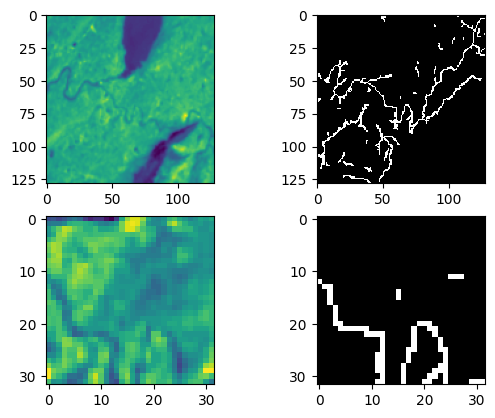

Faig ../data/preprocessed/32x32/ndvi


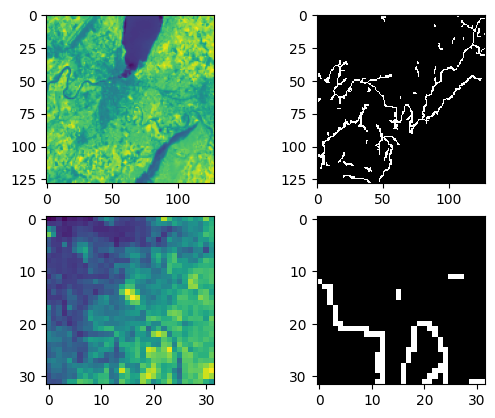

Faig ../data/preprocessed/32x32/slope


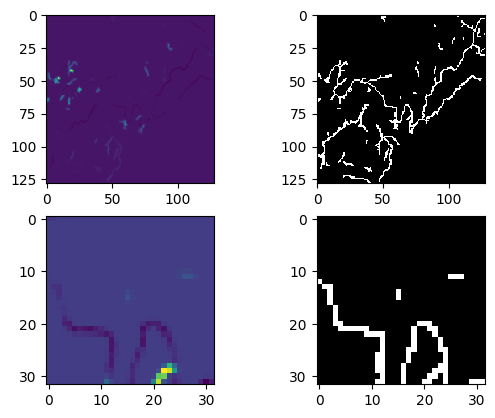

Faig ../data/preprocessed/32x32/altitude


Faig ../data/preprocessed/32x32/direction



Fent 64
Faig ../data/preprocessed/64x64/lst


Faig ../data/preprocessed/64x64/ndvi


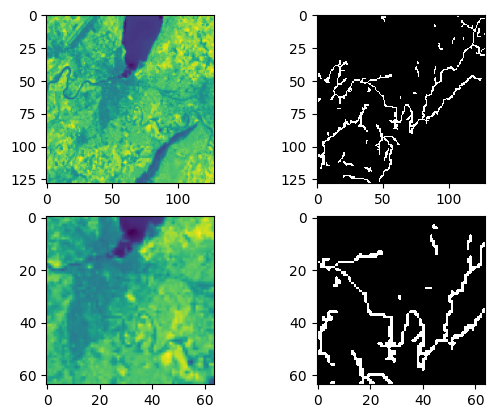

Faig ../data/preprocessed/64x64/slope


Faig ../data/preprocessed/64x64/altitude


Faig ../data/preprocessed/64x64/direction


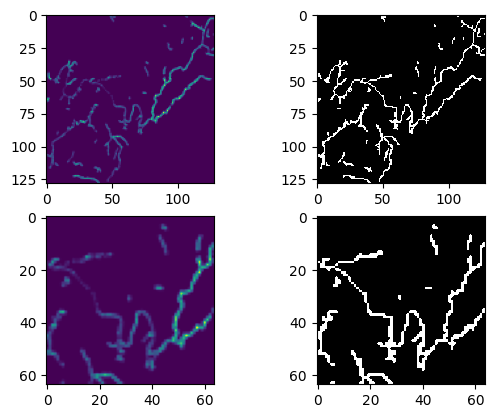

In [42]:
for crop_size in [8,16,32,64]:
    print('\nFent', crop_size)
    source='../data/preprocessed/'
    crop_folder = f'{source}{crop_size}x{crop_size}'
    os.makedirs(crop_folder, exist_ok=True)
    clear_directory(crop_folder)
    for variable in inputs:
        os.makedirs(f'{source}{crop_size}x{crop_size}/{variable}',exist_ok=True)
        print('Faig', f'{source}{crop_size}x{crop_size}/{variable}')
        for iii, cell in enumerate(os.listdir(f'{source}{variable}')):
            cell_folder = os.path.join(f'{source}{variable}',cell)
            if variable != 'altitude':
                imgs = [f'{cell_folder}/{file}' for file in os.listdir(cell_folder)]
            else:
                imgs = [cell_folder]
                
            if imgs!=[]:
                if variable !='altitude':
                    os.makedirs(f'{source}{crop_size}x{crop_size}/{variable}/{cell}',exist_ok=True) 
                if variable == 'lst' or variable == 'ndvi':
                    dates = [
                            match.group(0) 
                            for path in imgs if not path.endswith('.csv') 
                            if (match := re.search(r"\d{4}-\d{2}", path))  # Asignación condicional
                        ]
                    origin_imgs = [path for path in imgs if not path.endswith('.csv')]
                    dest_imgs = [f'{source}{crop_size}x{crop_size}/{variable}/{cell}/image_{time}.tiff' for time in dates]
                else:
                    dest_imgs = [f'{source}{crop_size}x{crop_size}/{variable}/{cell}/{cell}.tiff'] if variable != 'altitude' else \
                                [f'{source}{crop_size}x{crop_size}/{variable}/{cell}']
                    origin_imgs = imgs
                
                crop_rasters_with_metadata(origin_imgs, dest_imgs, crop_size)
                
                if iii == 0:
                    
                    with rasterio.open(dest_imgs[0]) as src:
                        r = src.read(1)
                    with rasterio.open(origin_imgs[0]) as src:
                        origin = src.read(1)

                    riv = river_masks[cell] if variable != 'altitude' else river_masks[cell.split('.')[0]]
                    meta = river_metas[cell] if variable != 'altitude' else river_metas[cell.split('.')[0]]
                    start_row = (meta.height - crop_size) // 2
                    start_col = (meta.width - crop_size) // 2
                    
                    # Aplicar el recorte
                    cropped_data = riv[start_row:start_row + crop_size, start_col:start_col + crop_size]
                    fig, ax = plt.subplots(2,2)
                    ax[0,0].imshow(origin)
                    binary_mask = np.where(riv > 0.0, 1.0, 0.0)
                    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
                    ax[0,1].imshow(binary_mask, cmap=cmap)
                    #ax[0,1].imshow(riv)
                    ax[1,0].imshow(r)
                    binary_mask = np.where(cropped_data > 0.0, 1.0, 0.0)
                    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
                    ax[1,1].imshow(binary_mask, cmap=cmap)
                    #ax[1,1].imshow(cropped_data)
                    plt.show()
                else: 
                    pass
                

../data/preprocessed/64x64/lst/cell_1
../data/preprocessed/32x32/lst/cell_1
../data/preprocessed/16x16/lst/cell_1
../data/preprocessed/8x8/lst/cell_1


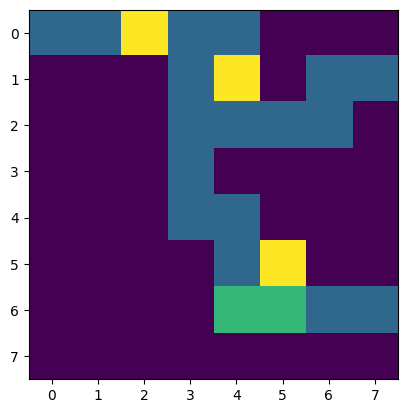

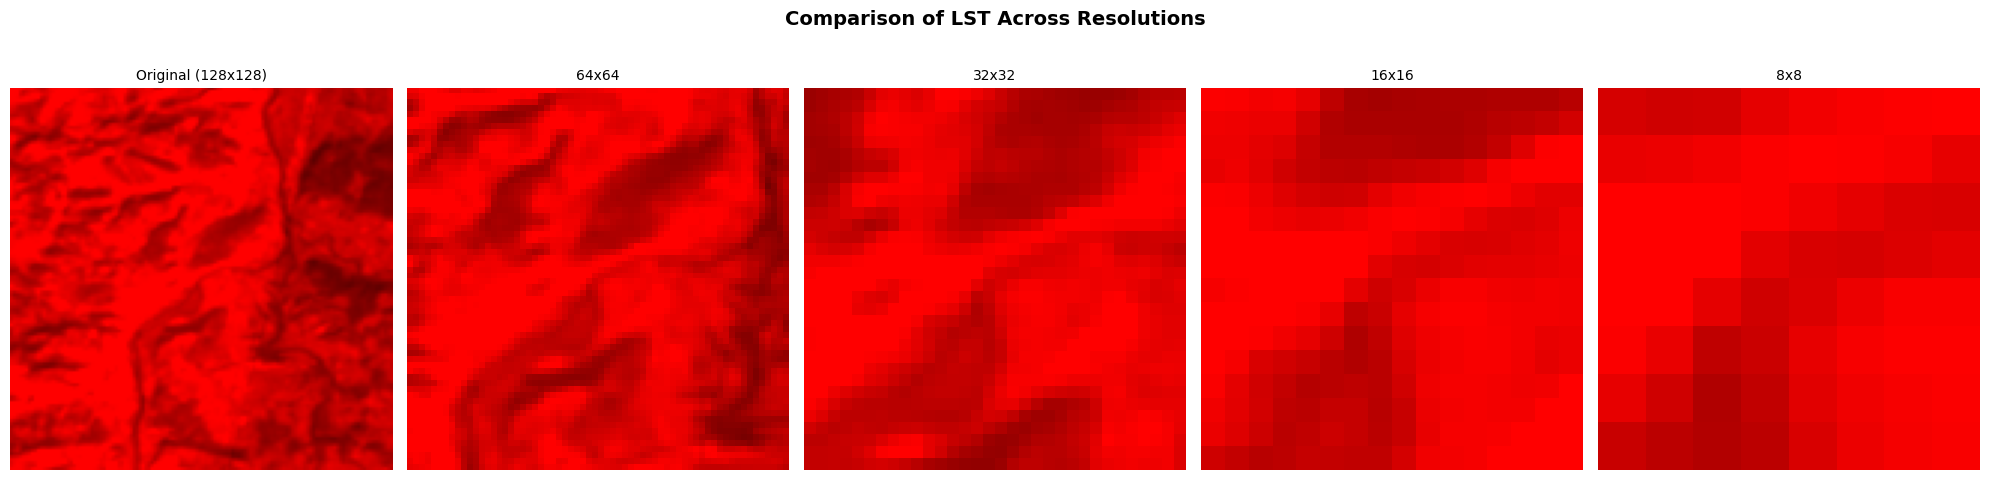

../data/preprocessed/64x64/ndvi/cell_1
../data/preprocessed/32x32/ndvi/cell_1
../data/preprocessed/16x16/ndvi/cell_1
../data/preprocessed/8x8/ndvi/cell_1


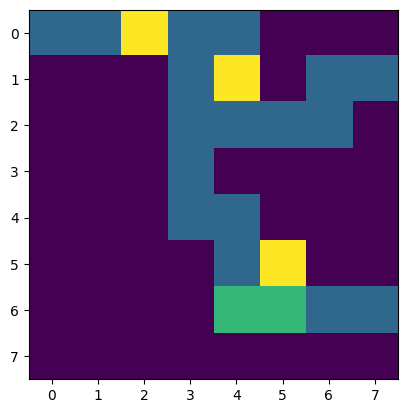

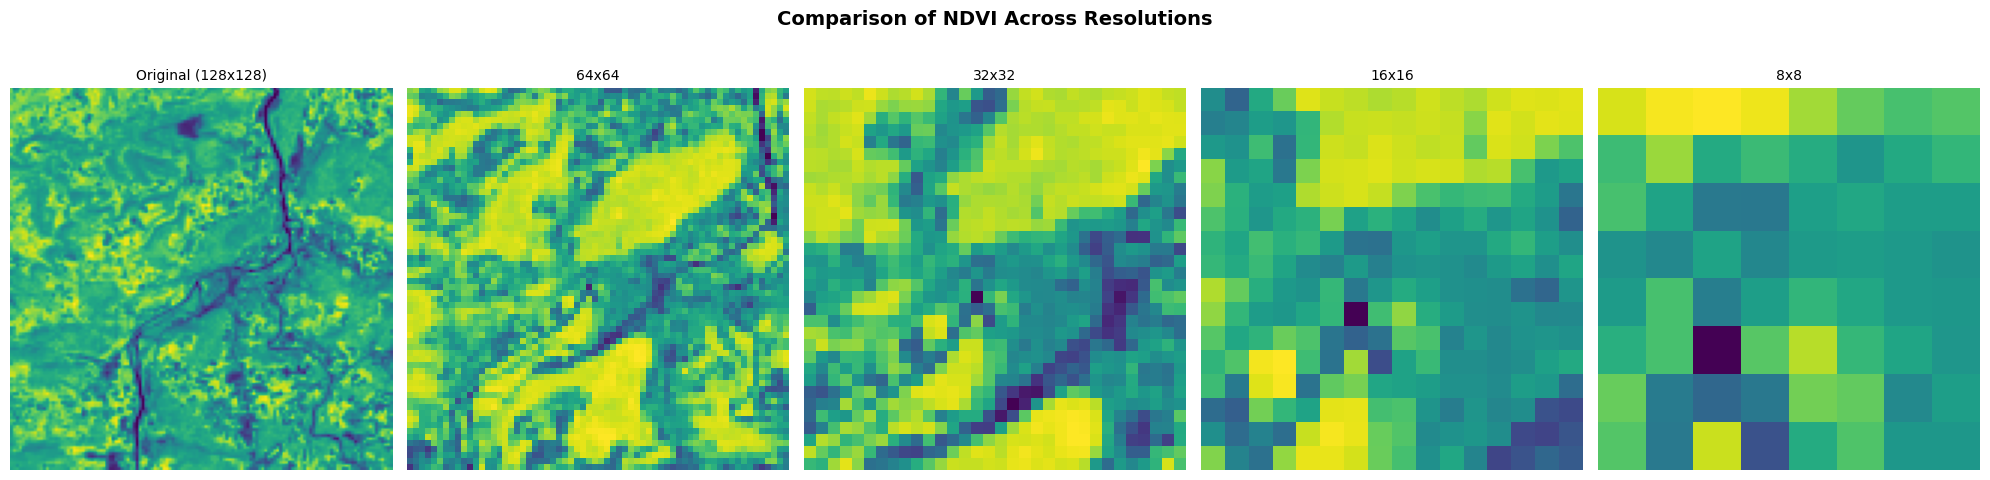

../data/preprocessed/64x64/slope/cell_1
../data/preprocessed/32x32/slope/cell_1
../data/preprocessed/16x16/slope/cell_1
../data/preprocessed/8x8/slope/cell_1


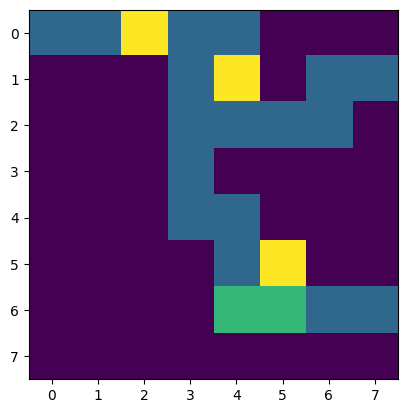

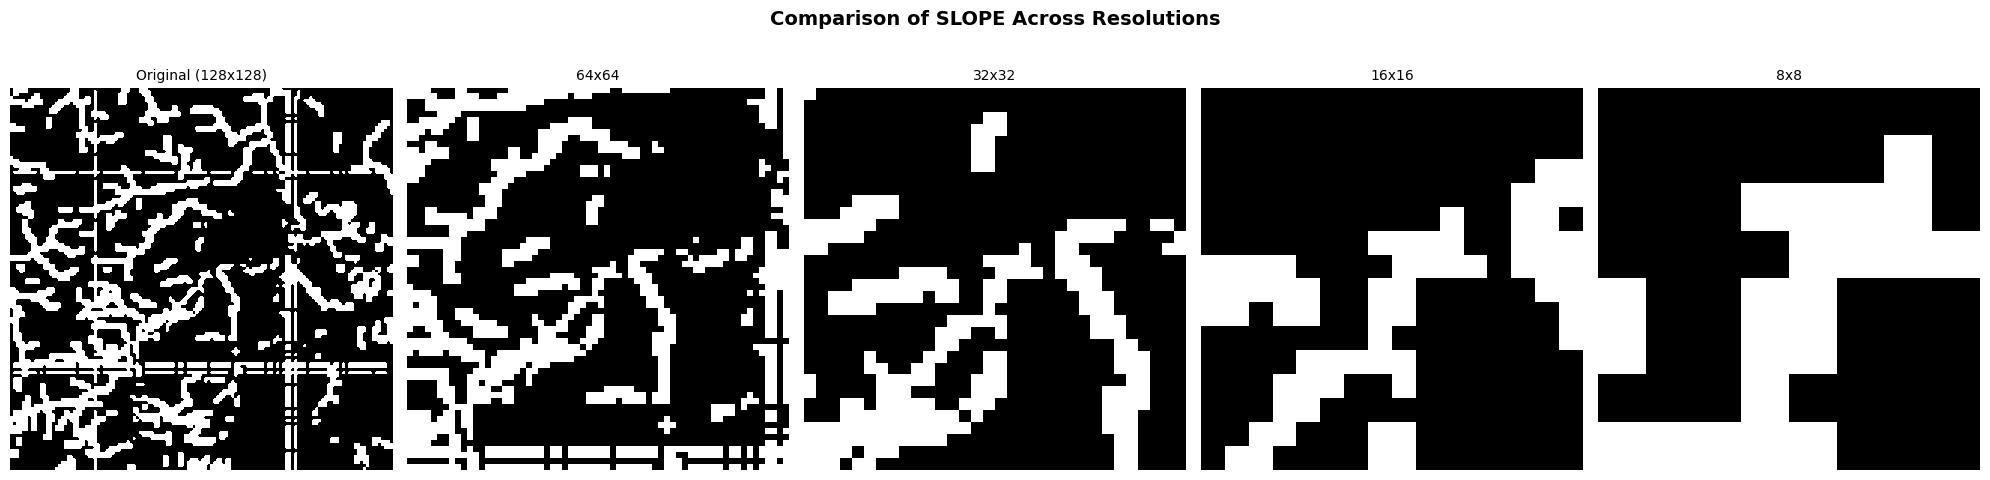

../data/preprocessed/64x64/altitude/cell_1
../data/preprocessed/32x32/altitude/cell_1
../data/preprocessed/16x16/altitude/cell_1
../data/preprocessed/8x8/altitude/cell_1


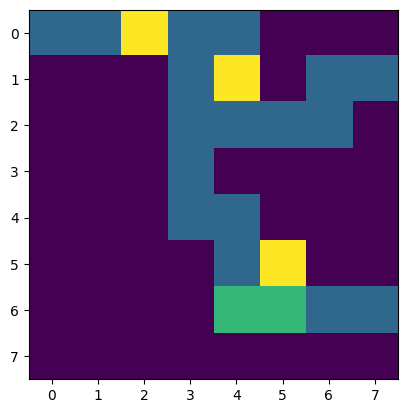

../data/preprocessed/64x64/direction/cell_1
../data/preprocessed/32x32/direction/cell_1
../data/preprocessed/16x16/direction/cell_1
../data/preprocessed/8x8/direction/cell_1


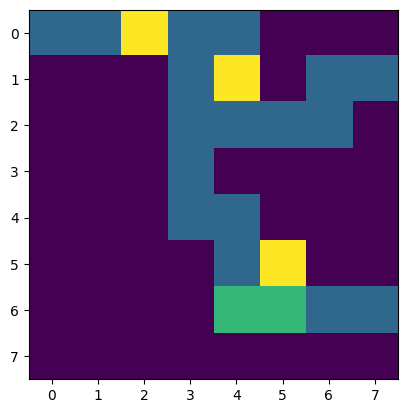

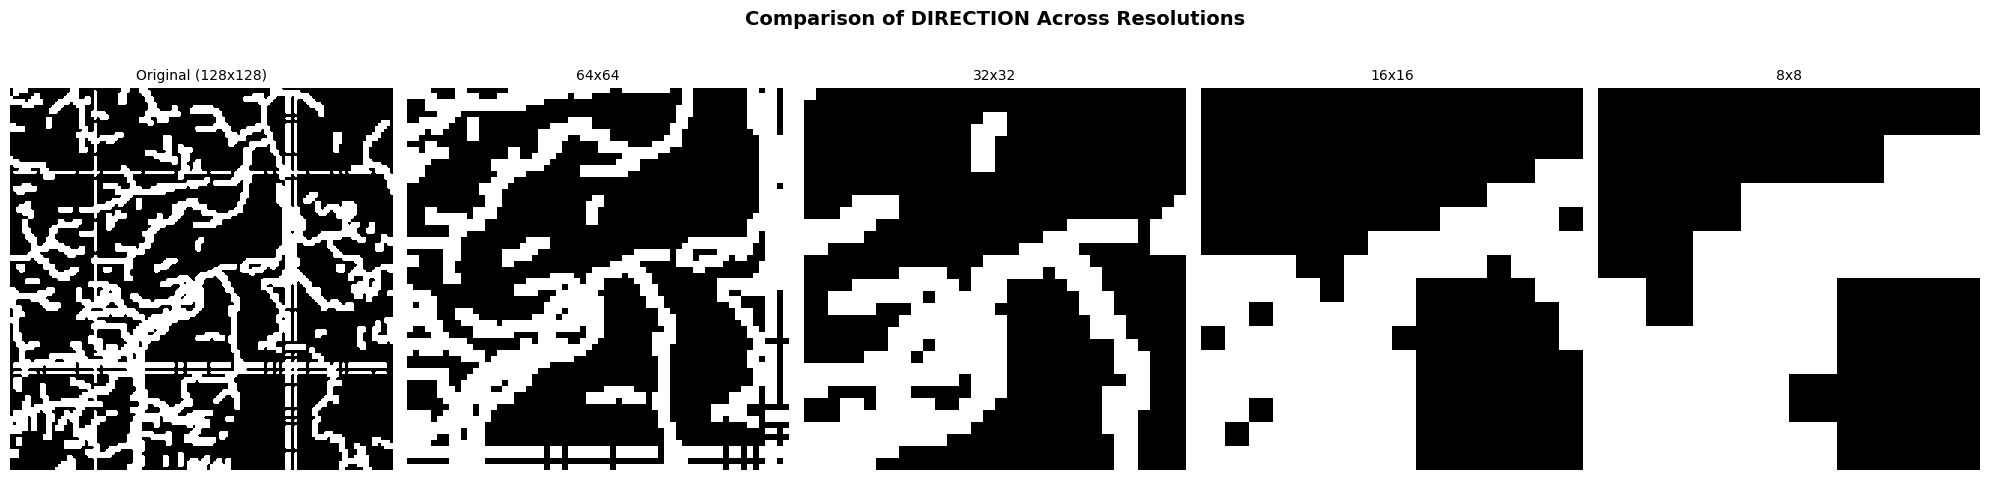

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt

def enhance_contrast(img, clip_min=0.05, clip_max=0.95):
    """
    Enhance contrast by limiting the range and normalizing.
    Adjust `clip_min` and `clip_max` for softer contrast changes.
    """
    lower, upper = np.percentile(img, [clip_min * 100, clip_max * 100])
    img = np.clip(img, lower, upper)
    return (img - lower) / (upper - lower)

# List of input variables
inputs = ['lst', 'ndvi', 'slope', 'altitude', 'direction']

# Loop through variables
for variable in inputs:
    # Determine if the image is RGB
    rgb = variable == 'lst'
    
    # Initialize a list to store the images for plotting
    images = []
    titles = []
    
    # Load the original image
    or_folder = f'../data/preprocessed/{variable}/cell_1'
    if variable != 'altitude':
        original_img, _ = load_raster(os.path.join(or_folder, os.listdir(or_folder)[0]), rgb)
    else:
        original_img, _ = load_raster(f'{or_folder}.tif', rgb)
        
        
    images.append(original_img)
    titles.append(f'Original ({original_img.shape[1]}x{original_img.shape[0]})')  # Add dimensions to title
    
    # Load cropped images for all resolutions
    for crop_size in [64, 32, 16, 8]:
        new_folder = f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/cell_1'
        print(new_folder)
        raster_file =  os.listdir(new_folder)[0] if variable != 'altitude' else f'{new_folder}.tif'
        raster_folder = os.path.join(new_folder,raster_file) if variable != 'altitude' else raster_file
        
        new_img, _ = load_raster(raster_folder, rgb)
        images.append(new_img)
        titles.append(f'{crop_size}x{crop_size}')

        riv = river_masks[cell] if variable != 'altitude' else river_masks[cell.split('.')[0]]
        meta = river_metas[cell] if variable != 'altitude' else river_metas[cell.split('.')[0]]
        start_row = (meta.height - crop_size) // 2
        start_col = (meta.width - crop_size) // 2
        cropped_data = riv[start_row:start_row + crop_size, start_col:start_col + crop_size]
        plt.imshow(cropped_data)
    
    # Plot all images in a single row
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        if variable == 'lst':
            ax[i].imshow(enhance_contrast(img), cmap='viridis' if not rgb else None)
        elif variable in ['direction', 'slope']:
            #threshold = np.percentile(img, 95)
            binary_mask = np.where(img > 1.0, 1.0, 0.0)
            cmap = plt.cm.colors.ListedColormap(['black', 'white'])
            ax[i].imshow(binary_mask, cmap=cmap)
        elif variable == 'altitude':
            ax[i].imshow(img, cmap='viridis' if not rgb else None)
        else:
            ax[i].imshow(np.clip(img * (6 / 255), 0, 1), cmap='viridis' if not rgb else None)
            
        ax[i].set_title(titles[i], fontsize=10)
        ax[i].axis('off')

    '''
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))  # Adjust figsize for clarity
    for i, img in enumerate(images):
        print(i)
        if variable=='lst':
            ax[i].imshow(enhance_contrast(img), cmap='viridis' if not rgb else None)
        elif variable in ['direction','slope']:
            binary_mask = np.where(img > 1.0, 1.0, 0.0)
            cmap = plt.cm.colors.ListedColormap(['black', 'white'])
            ax[i].imshow(binary_mask, cmap=cmap)
        elif variable == 'altitude':
            ax[i].imshow(img, cmap='viridis' if not rgb else None)
        else:
            ax[i].imshow(np.clip(img * (6 / 255), 0, 1), cmap='viridis' if not rgb else None)
            
        ax[i].set_title(titles[i], fontsize=10)
        ax[i].axis('off')'''
    fig.suptitle(f'Comparison of {variable.upper()} Across Resolutions', fontsize=14, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'../plots/{variable}_resolution_comparison.png', dpi=300)
    plt.show()

    
    '''

    riv = river_masks[cell] if variable != 'altitude' else river_masks[cell.split('.')[0]]
    meta = river_metas[cell] if variable != 'altitude' else river_metas[cell.split('.')[0]]
    start_row = (meta.height - crop_size) // 2
    start_col = (meta.width - crop_size) // 2
    cropped_data = riv[start_row:start_row + crop_size, start_col:start_col + crop_size]
    plt.imshow(cropped_data)
    # Add a central title for the row
    fig.suptitle(f'Comparison of {variable.upper()} Across Resolutions', fontsize=14, weight='bold')
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'../plots/{variable}_resolution_comparison.png', dpi=300)
    plt.show()'''


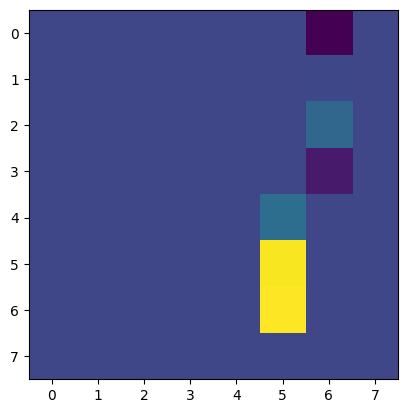

In [8]:
cut,mm=  load_raster('../data/preprocessed/8x8/slope/cell_21/cell_21.tiff',False)
#original,m = load_raster('../data/preprocessed/discharge/cell_67/cell_67.tif',False)
plt.imshow(cut)
plt.show()

In [89]:
mm.bounds

BoundingBox(left=2666070.1111025596, bottom=1268288.6415979539, right=2667989.8568402207, top=1270208.3864669106)

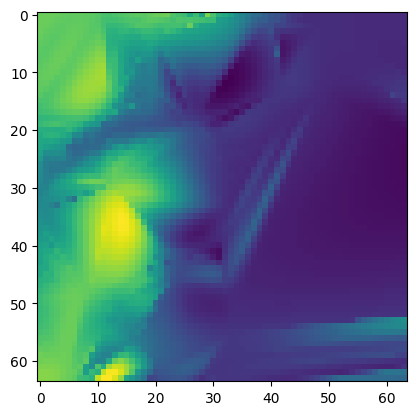

BoundingBox(left=2665301.4629068165, bottom=1267489.9977364542, right=2668788.5010631154, top=1270977.0343148329)

In [24]:
cut,mm=  load_raster('../data/preprocessed/altitude/cell_20.tif',False)
#original,m = load_raster('../data/preprocessed/discharge/cell_67/cell_67.tif',False)
plt.imshow(cut)
plt.show()
mm.bounds

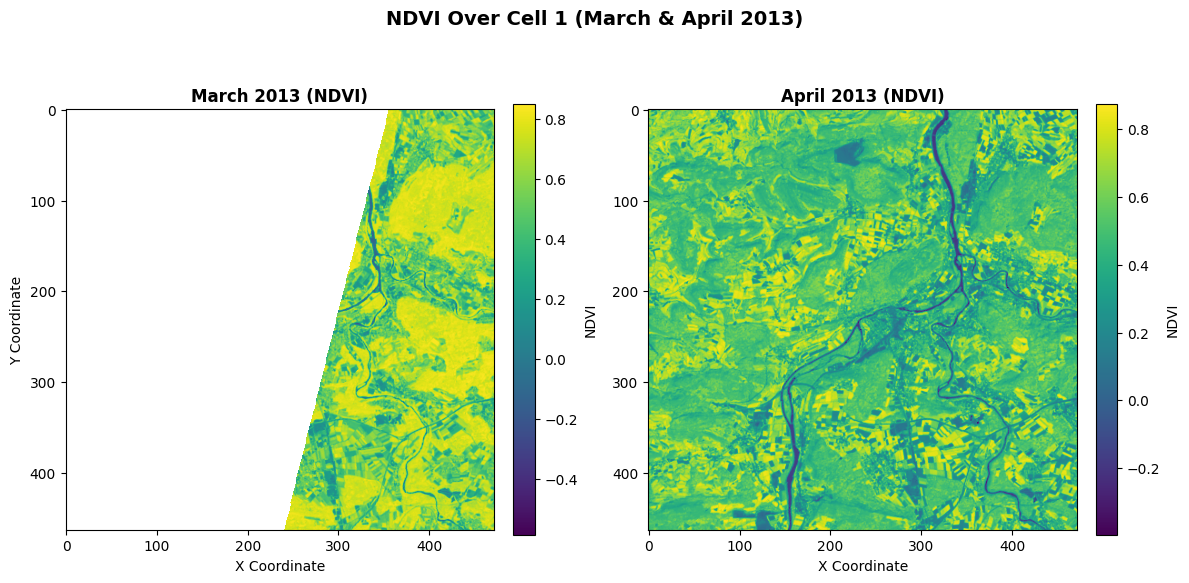

In [15]:
cut,mm=  load_raster('../data/raw/ndvi/cell_1/ndvi_2013-03.tiff',False)
cut2,mm=  load_raster('../data/raw/ndvi/cell_1/ndvi_2013-04.tiff',False)
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for better horizontal layout

# Display the first image with title and labels
im1 = ax[0].imshow(cut, cmap='viridis')  # Use a colormap to make NDVI values visually intuitive
ax[0].set_title('March 2013 (NDVI)', fontsize=12, weight='bold')
ax[0].set_xlabel('X Coordinate', fontsize=10)
ax[0].set_ylabel('Y Coordinate', fontsize=10)
plt.colorbar(im1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04, label='NDVI')

# Display the second image with title and labels
im2 = ax[1].imshow(cut2, cmap='viridis')
ax[1].set_title('April 2013 (NDVI)', fontsize=12, weight='bold')
ax[1].set_xlabel('X Coordinate', fontsize=10)
plt.colorbar(im2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04, label='NDVI')

# Add a central title for the entire figure
fig.suptitle('NDVI Over Cell 1 (March & April 2013)', fontsize=14, weight='bold', y=0.95)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Reserve space for suptitle

# Save and show the figure
plt.savefig('../plots/preprocess_show.png', dpi=300)  # Save at high resolution
plt.show()


# Pixel wise dataset creation

### Raster masks

Bounds for cell_37: [2627066.54110279 1118941.95336085 2640985.71263633 1132861.11854738]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_37


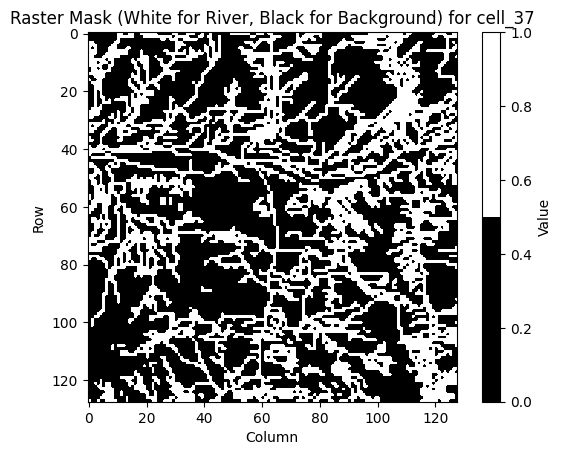

6128
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_37.tif with bounds 7.789739506031901, 46.220706592184285, 7.971035578637076, 46.34654802844904, EPSG:4326
Bounds for cell_8: [2750780.87158389 1227620.2907106  2762610.47968351 1241574.55750319]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_8


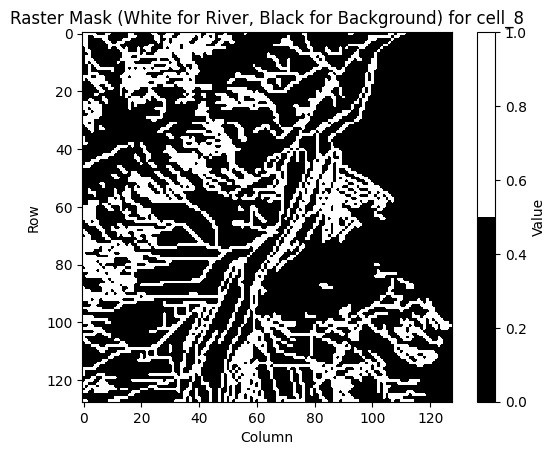

4861
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_8.tif with bounds 9.428118408643325, 47.17983361730296, 9.585133093783679, 47.30772531065502, EPSG:4326
Bounds for cell_33: [2586377.82533914 1186081.34626823 2600300.30365875 1200003.81829127]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_33


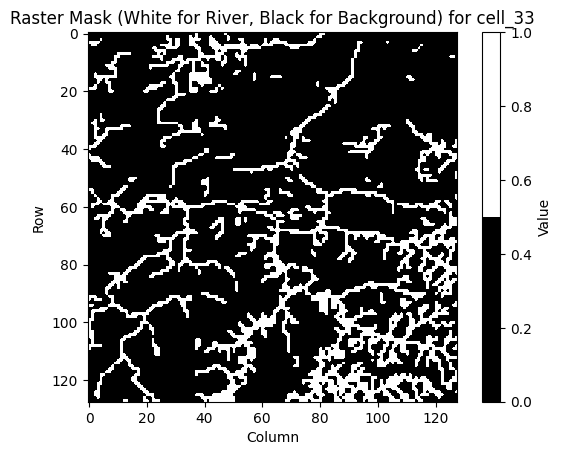

3092
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_33.tif with bounds 7.259702439241475, 46.82576785095841, 7.4425753120937514, 46.951099436808974, EPSG:4326
Bounds for cell_9: [2485394.28547592 1109635.08712941 2493545.52428299 1119278.04743357]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_9


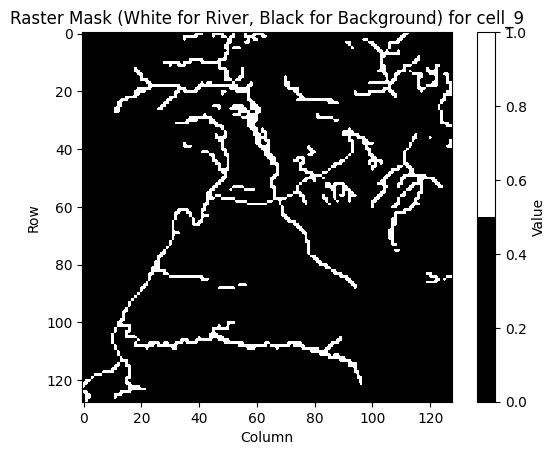

1336
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_9.tif with bounds 5.955700977161222, 46.12845728546201, 6.060496820598469, 46.21635315657026, EPSG:4326
Bounds for cell_42: [2788816.86210531 1158932.17238049 2802767.28332073 1172882.58717871]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_42


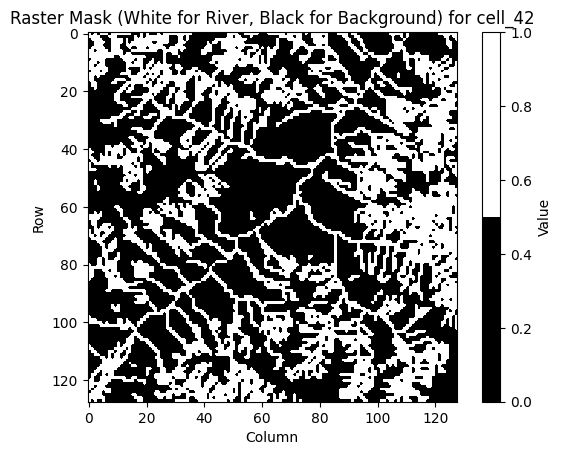

6452
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_42.tif with bounds 9.90124391819627, 46.55134545932689, 10.089139787937953, 46.680426363174, EPSG:4326
Bounds for cell_78: [2597851.80712877 1185717.31744749 2611776.32047779 1199641.82449536]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_78


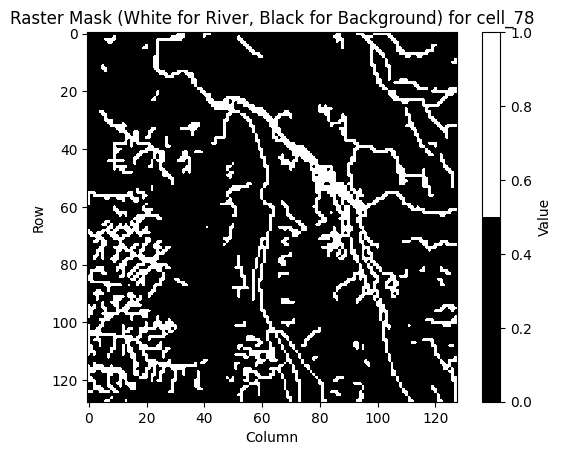

2733
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_78.tif with bounds 7.410444761879143, 46.82250397241049, 7.5932913865018525, 46.94785944290967, EPSG:4326
Bounds for cell_6: [2639084.55648717 1260508.11099889 2653029.41617011 1271907.22765843]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_6


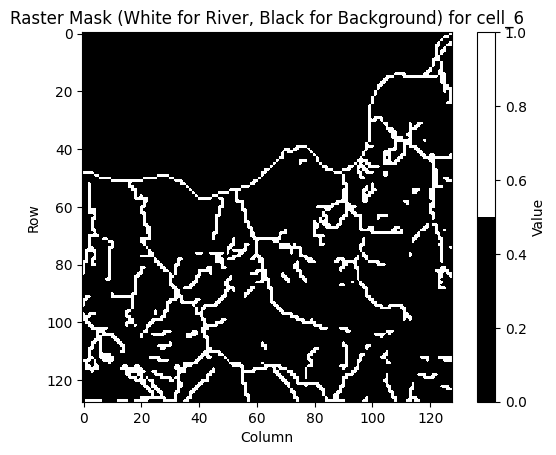

1708
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_6.tif with bounds 7.9575273004910585, 47.493290931609465, 8.143697632914007, 47.59571167358068, EPSG:4326
Bounds for cell_46: [2565590.71659701 1237494.31141783 2579519.31535053 1251422.90391386]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_46


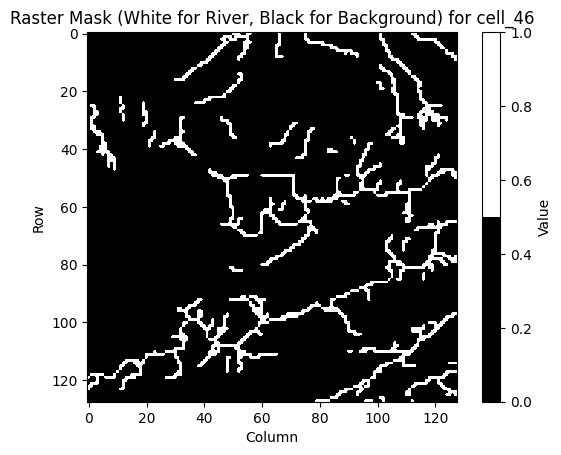

1502
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_46.tif with bounds 6.9836998371047025, 47.28783459036275, 7.167835742734639, 47.41323987851493, EPSG:4326
Bounds for cell_31: [2758408.45043498 1197938.83044189 2772359.62328283 1211889.9968962 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_31


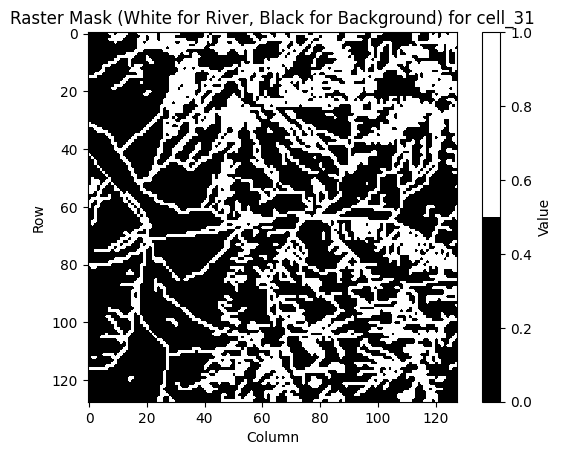

6003
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_31.tif with bounds 9.5187314285739, 46.910394991211824, 9.70663006428011, 47.03889088440924, EPSG:4326
Bounds for cell_59: [2596033.08643687 1195511.60893957 2609959.02225082 1209437.53845517]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_59


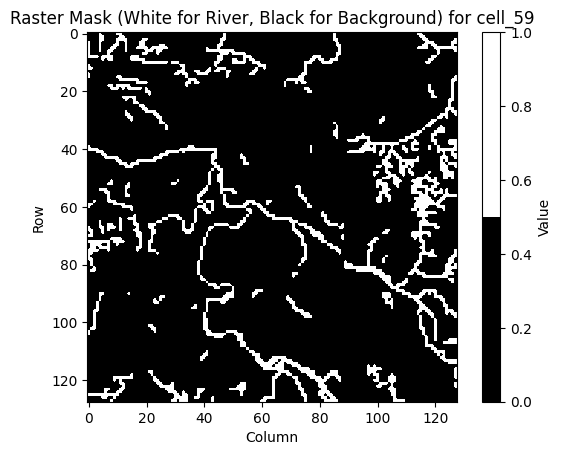

1870
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_59.tif with bounds 7.386441546785222, 46.91066233445913, 7.5696451848008826, 47.03597350759163, EPSG:4326
Bounds for cell_63: [2525072.58841548 1149326.98514098 2538975.62789048 1161118.15532581]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_63


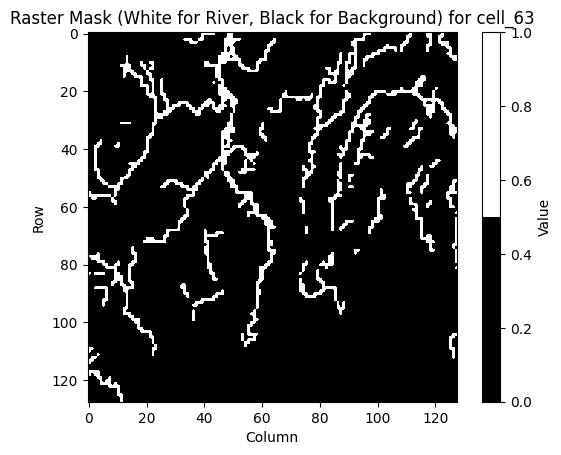

1552
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_63.tif with bounds 6.461639149874199, 46.49119954141588, 6.64350593696737, 46.598473570799804, EPSG:4326
Bounds for cell_11: [2581254.85740019 1212055.41088318 2595181.22153303 1225981.76873779]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_11


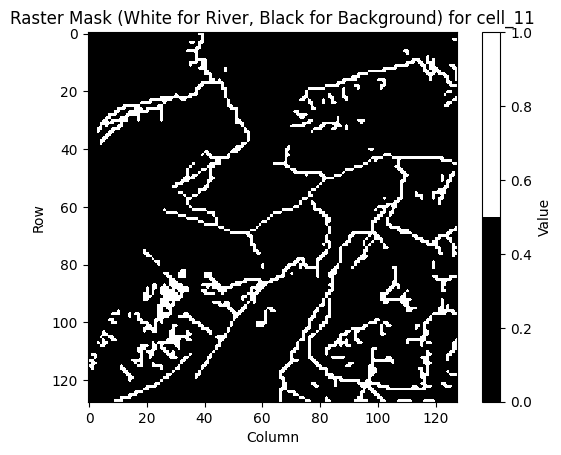

1817
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_11.tif with bounds 7.191837931123985, 47.05928340504092, 7.375191830086064, 47.184629396395685, EPSG:4326
Bounds for cell_36: [2623759.24652903 1200306.74951638 2637690.84758824 1214238.34426244]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_36


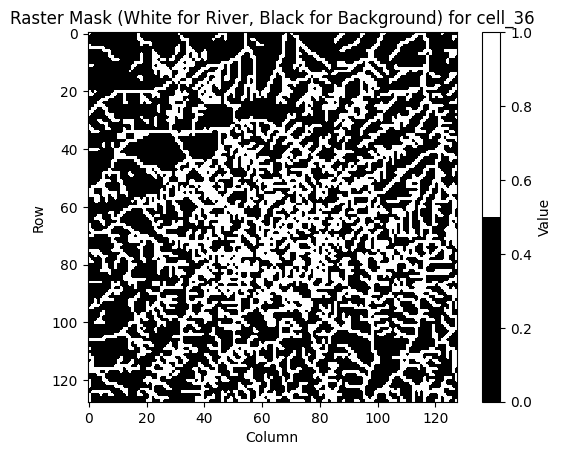

6324
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_36.tif with bounds 7.750763182466903, 46.95279575576701, 7.934904514862899, 47.078733509183216, EPSG:4326
Bounds for cell_65: [2781822.10843111 1144718.40955209 2795770.06648123 1158666.36118403]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_65


5511
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_65.tif with bounds 9.804606435757712, 46.42525141212122, 9.991692209425205, 46.55453166273482, EPSG:4326
Bounds for cell_56: [2682163.2809247  1275010.8128678  2696116.65480634 1288964.18041926]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_56


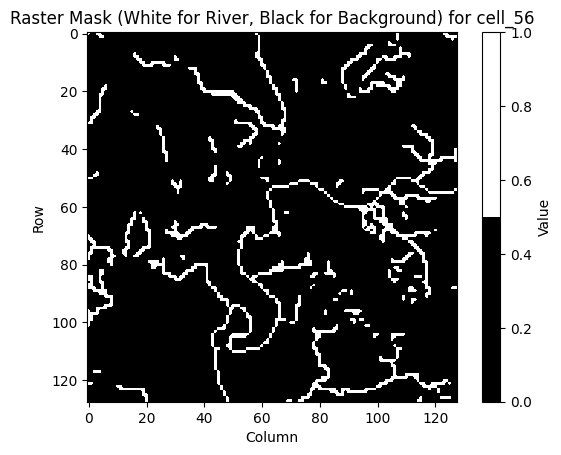

1354
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_56.tif with bounds 8.531727172176957, 47.61937927194279, 8.720164203517156, 47.74609450410798, EPSG:4326
Bounds for cell_12: [2678535.73386719 1189082.17580992 2692474.37222473 1203020.80781476]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_12


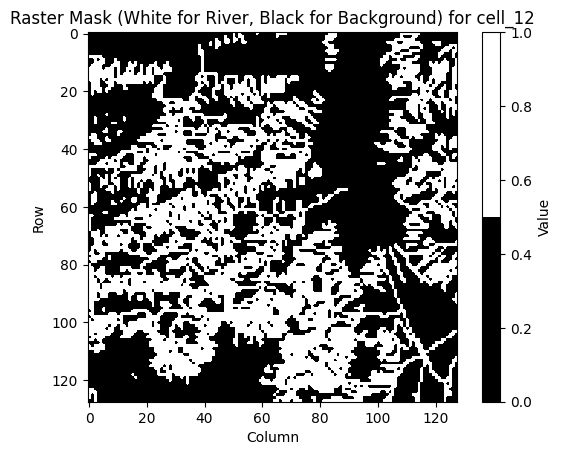

6601
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_12.tif with bounds 8.468368200080693, 46.8465189200334, 8.65368630757913, 46.97273505914255, EPSG:4326
Bounds for cell_72: [2503121.36571067 1133136.90387211 2516672.54849862 1147032.41391121]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_72


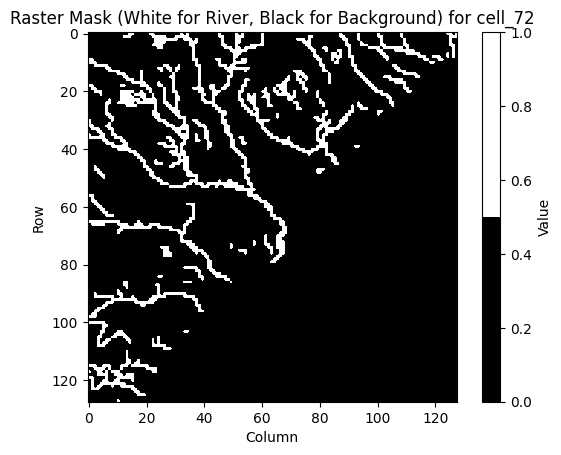

1539
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_72.tif with bounds 6.177541688038145, 46.34277952643656, 6.353746169153314, 46.46937454127454, EPSG:4326
Bounds for cell_24: [2742058.69032779 1237239.12772708 2756013.30861971 1251193.73964242]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_24


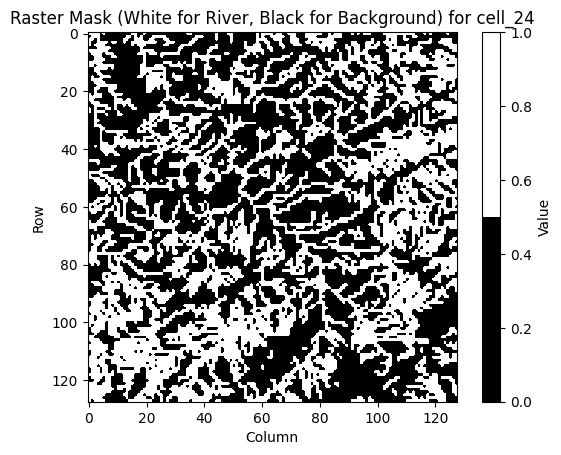

7315
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_24.tif with bounds 9.316113436442183, 47.26772230226755, 9.505077077887604, 47.396188866543014, EPSG:4326
Bounds for cell_38: [2538492.62179302 1173914.17221067 2552403.53982029 1187825.08397066]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_38


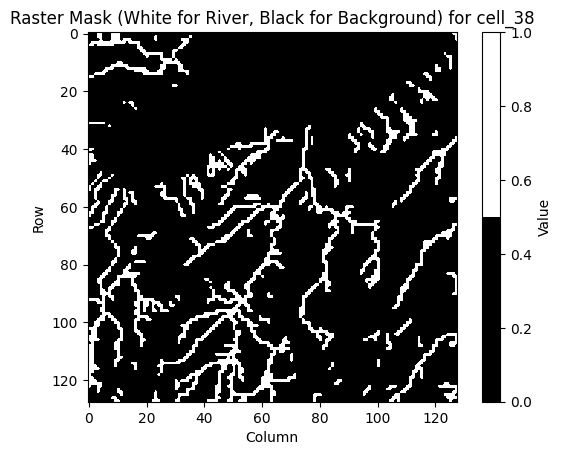

1990
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_38.tif with bounds 6.632398756986986, 46.713693909077676, 6.816122320158943, 46.83976441781316, EPSG:4326
Bounds for cell_80: [2554713.37920808 1180361.92214104 2568628.76681631 1194277.30347414]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_80


2194
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_80.tif with bounds 6.8449618299953645, 46.77302417562118, 7.027852278066839, 46.89883049461957, EPSG:4326
Bounds for cell_25: [2601734.24418987 1141332.70322886 2615651.96998269 1155250.4226994 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_25


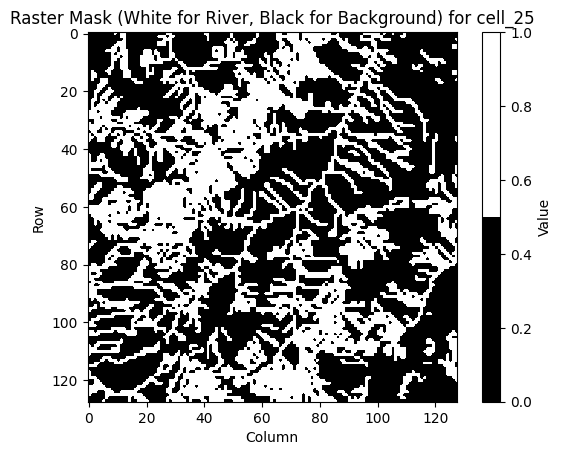

6645
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_25.tif with bounds 7.461202194868708, 46.42323687964841, 7.6427061224861905, 46.54853644152975, EPSG:4326
Bounds for cell_21: [2658676.96287329 1251711.4904193  2672623.02336698 1265657.54459247]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_21


2179
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_21.tif with bounds 8.217164044021997, 47.41229730473287, 8.402490733562397, 47.538973573342844, EPSG:4326
Bounds for cell_68: [2626768.01086206 1164545.47255099 2640694.15311289 1178471.60847355]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_68


5537
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_68.tif with bounds 7.788190553244467, 46.630921282969936, 7.971215506133764, 46.75689143762558, EPSG:4326
Bounds for cell_32: [2622614.29035072 1212171.80718115 2636547.7806229  1226105.29114536]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_32


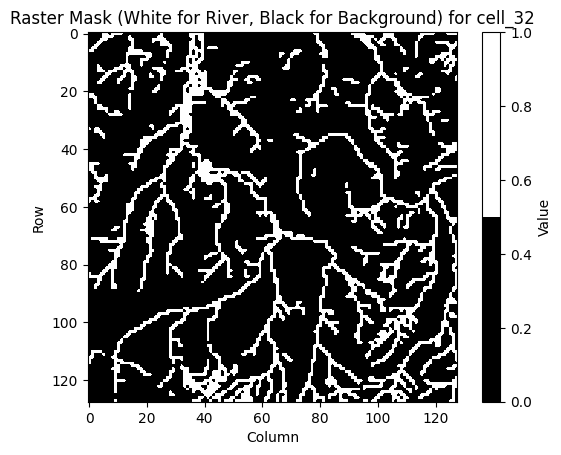

3089
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_32.tif with bounds 7.736374523753779, 47.05957357713578, 7.920821782640892, 47.1854916318842, EPSG:4326
Bounds for cell_10: [2655862.71374987 1245605.23717842 2669807.2850706  1259549.80217843]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_10


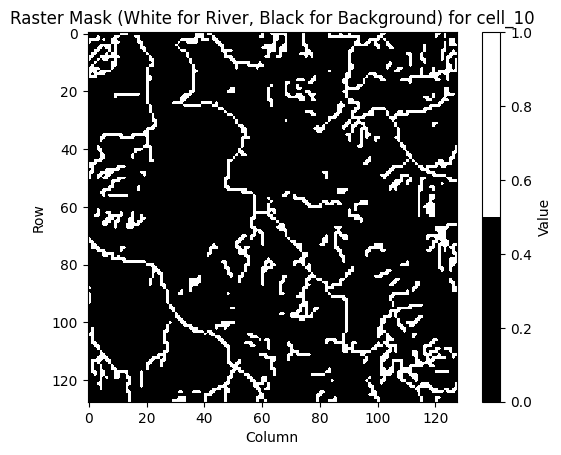

2145
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_10.tif with bounds 8.178393861343759, 47.35773456191865, 8.364682941043847, 47.484214319678586, EPSG:4326
Bounds for cell_61: [2726580.14560012 1256207.61747763 2740535.8187514  1270163.28426541]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_61


3397
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_61.tif with bounds 9.1171727480495, 47.44199819720999, 9.305931817546208, 47.56994827888416, EPSG:4326
Bounds for cell_17: [2593762.69849071 1191034.21818456 2607687.41941702 1204958.93281396]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_17


2227
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_17.tif with bounds 7.3566867029274094, 46.87041341227252, 7.539695278552561, 46.99568888085246, EPSG:4326
Bounds for cell_14: [2686523.84630739 1265530.36405784 2700476.10731137 1279482.61872806]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_14


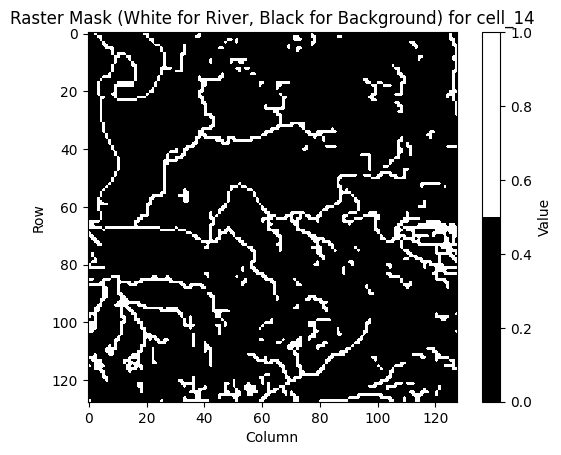

1894
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_14.tif with bounds 8.587753878541983, 47.53312761895927, 8.776032307096639, 47.660240871595256, EPSG:4326
Bounds for cell_18: [2680439.82680905 1270170.35502292 2694392.11881684 1284122.6406995 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_18


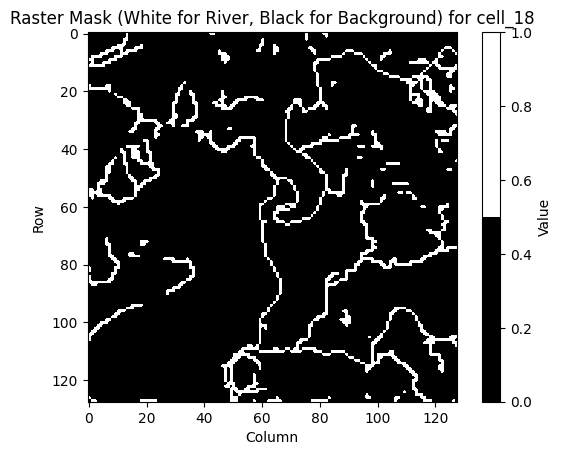

1465
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_18.tif with bounds 8.507815943732, 47.57546480407291, 8.696016794647695, 47.702179914556964, EPSG:4326
Bounds for cell_1: [2649986.52401692 1252381.06002334 2663931.46256555 1266325.99225707]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_1


2264
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_1.tif with bounds 8.101117686412541, 47.4192226310551, 8.28729717481431, 47.54558040563741, EPSG:4326
Bounds for cell_71: [2578144.01980506 1192232.55468704 2592066.09862688 1206154.62722251]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_71


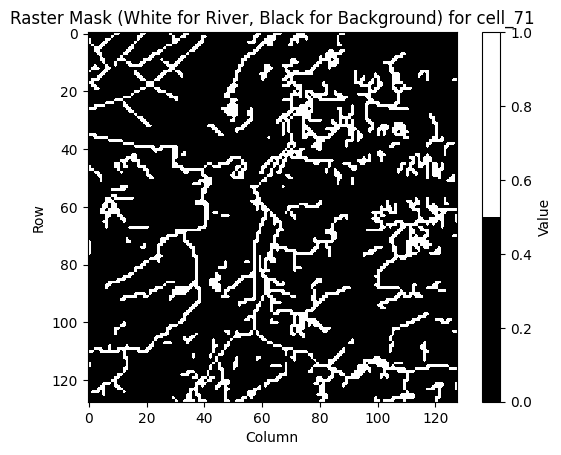

2650
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_71.tif with bounds 7.15124743332444, 46.88095272537814, 7.334527414458936, 47.006330239335, EPSG:4326
Bounds for cell_45: [2718198.92561716 1214411.35955028 2732147.12301956 1228359.55058495]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_45


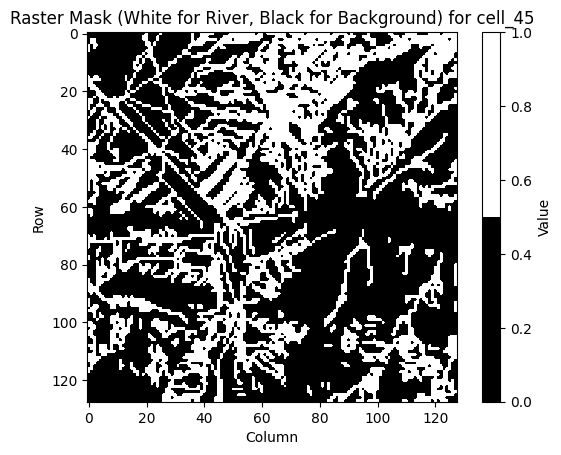

5886
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_45.tif with bounds 8.995179778516839, 47.06762534433853, 9.182497771552915, 47.19521748051796, EPSG:4326
Bounds for cell_23: [2681296.73413141 1199199.18456515 2695237.35147193 1213139.79555613]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_23


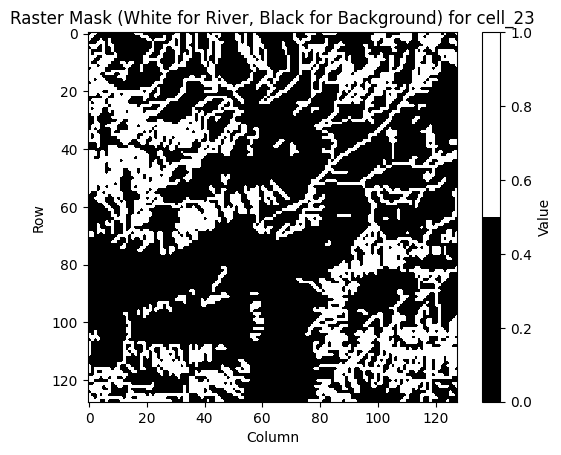

5233
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_23.tif with bounds 8.506361367639924, 46.93710801750557, 8.692327546739586, 47.06407568831711, EPSG:4326
Bounds for cell_28: [2550696.73177902 1126332.22027479 2564601.52090682 1140237.00310366]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_28


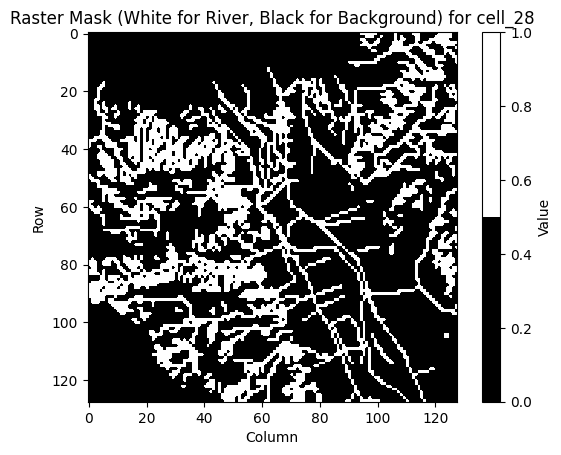

4506
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_28.tif with bounds 6.7978817134226315, 46.286957793642195, 6.979068164255999, 46.41253079483546, EPSG:4326
Bounds for cell_60: [2760214.62917161 1250830.06512052 2768745.72568098 1263578.10611496]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_60


2273
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_60.tif with bounds 9.56086054933785, 47.38679461220894, 9.673811372221, 47.501435997921575, EPSG:4326
Bounds for cell_19: [2693753.87802538 1211155.3302863  2707698.18163554 1225099.62754285]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_19


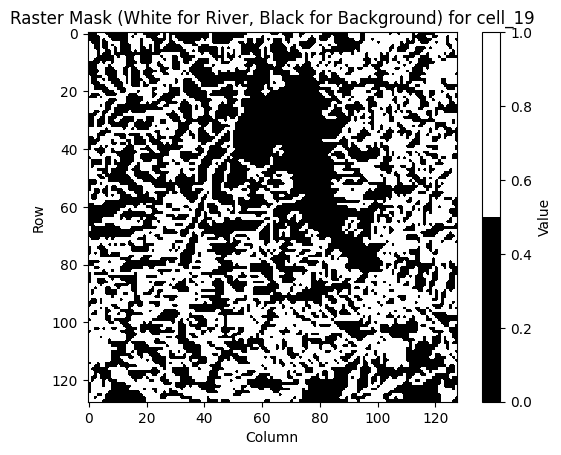

7947
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_19.tif with bounds 8.672422100582786, 47.04273175406289, 8.858901379305573, 47.170155065401296, EPSG:4326
Bounds for cell_43: [2652993.96454582 1256130.50194349 2666940.01406776 1270076.54515001]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_43


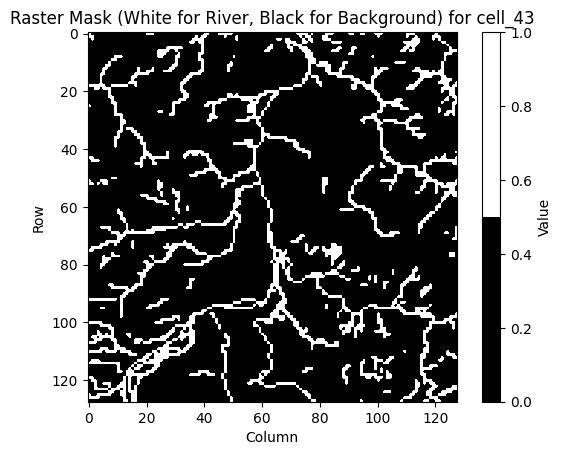

2356
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_43.tif with bounds 8.141367514210941, 47.452634196739254, 8.328249988986867, 47.57924847665569, EPSG:4326
Bounds for cell_35: [2706678.09969657 1106535.42705897 2720610.16441894 1120467.48538837]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_35


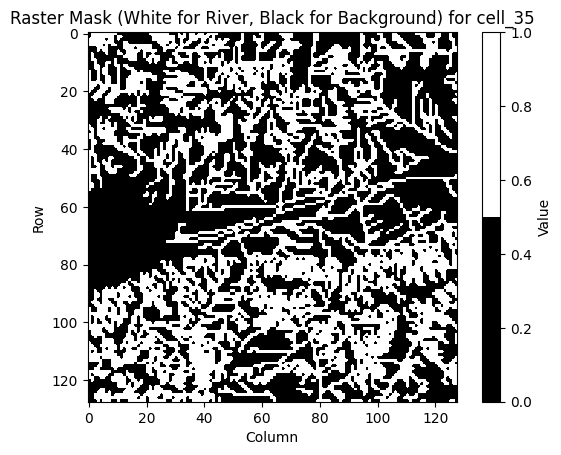

7083
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_35.tif with bounds 8.818459956092166, 46.09956602985378, 9.001771491428734, 46.2270723391489, EPSG:4326
Bounds for cell_20: [2660070.90626373 1262259.44401583 2674019.05890267 1276207.59033576]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_20


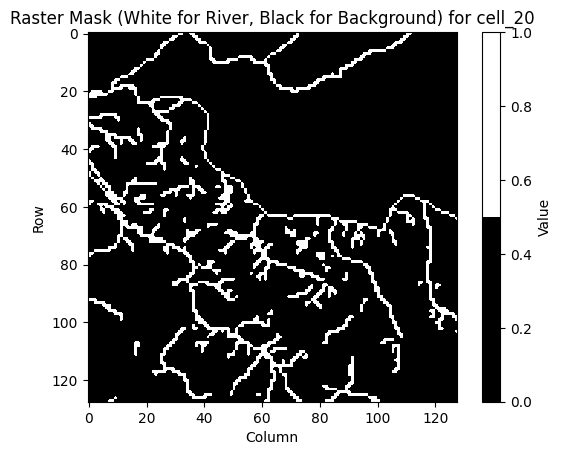

1632
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_20.tif with bounds 8.23653167514662, 47.5072467816107, 8.422293228067696, 47.63344480950194, EPSG:4326
Bounds for cell_58: [2693777.86822811 1211258.32057931 2707722.19122484 1225202.63722254]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_58


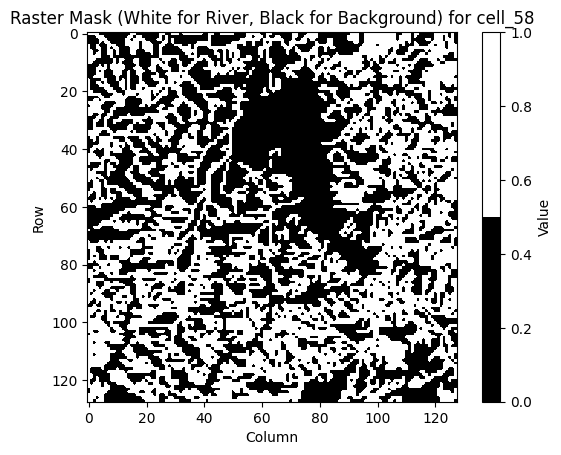

7984
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_58.tif with bounds 8.672764097006699, 47.04364412320009, 8.859410330655072, 47.171128564292125, EPSG:4326
Bounds for cell_57: [2711849.24135931 1241472.71037022 2725800.75495659 1255424.21761013]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_57


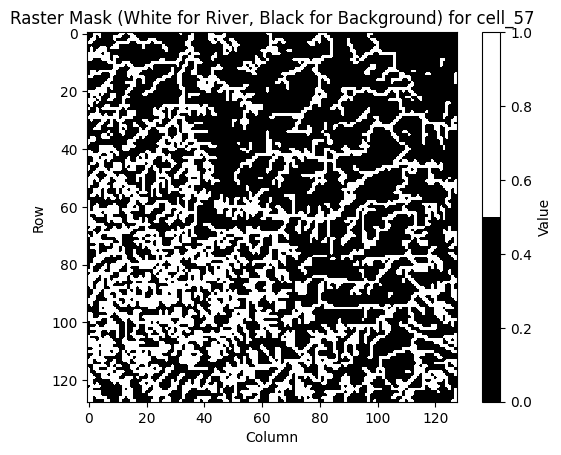

6038
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_57.tif with bounds 8.918022876625722, 47.31216015534386, 9.105503706952975, 47.440055499542446, EPSG:4326
Bounds for cell_7: [2691667.63994434 1216063.09939362 2705612.41041199 1230007.86350963]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_7


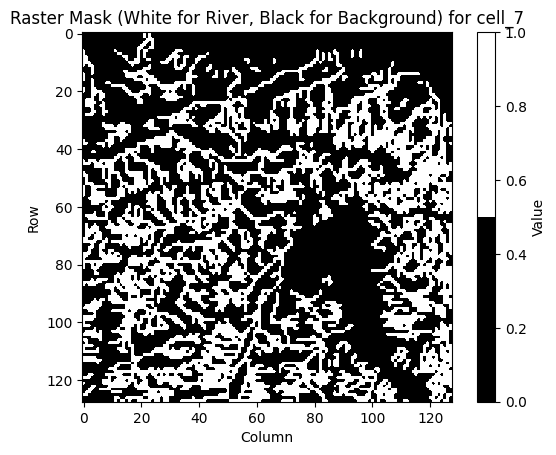

5930
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_7.tif with bounds 8.645987575750048, 47.08719431175354, 8.832024132301626, 47.21428133599159, EPSG:4326
Bounds for cell_41: [2690255.7214862  1216306.1824609  2704200.32865503 1230250.78327965]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_41


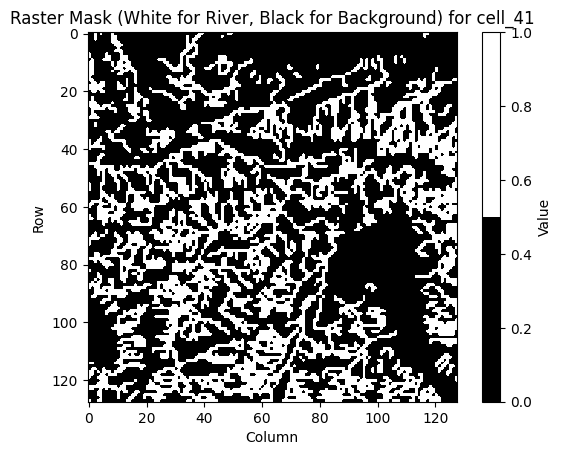

5619
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_41.tif with bounds 8.627403794461191, 47.089696631226715, 8.813829358946009, 47.21696478520136, EPSG:4326
Bounds for cell_73: [2567713.7885182  1254249.99667135 2574810.62038256 1261430.39417613]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_73


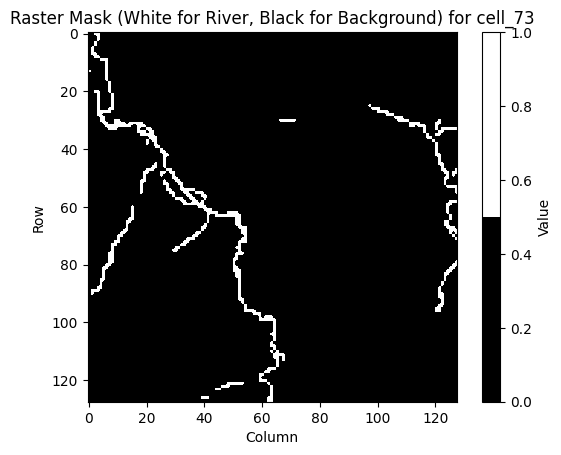

541
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_73.tif with bounds 7.010155014088872, 47.438409994884054, 7.104545926438782, 47.50283427185149, EPSG:4326
Bounds for cell_64: [2652168.21481705 1264862.76242141 2666115.74673903 1276278.47815331]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_64


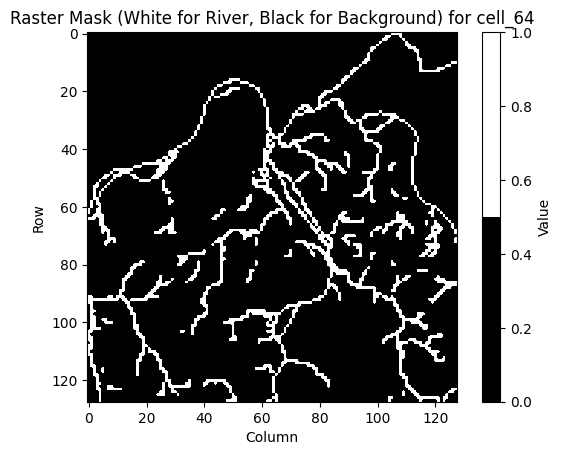

1707
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_64.tif with bounds 8.131788185737328, 47.53121932915474, 8.318189284522832, 47.63406289371739, EPSG:4326
Bounds for cell_26: [2586787.14196277 1111676.58247931 2600697.13316372 1125586.56735339]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_26


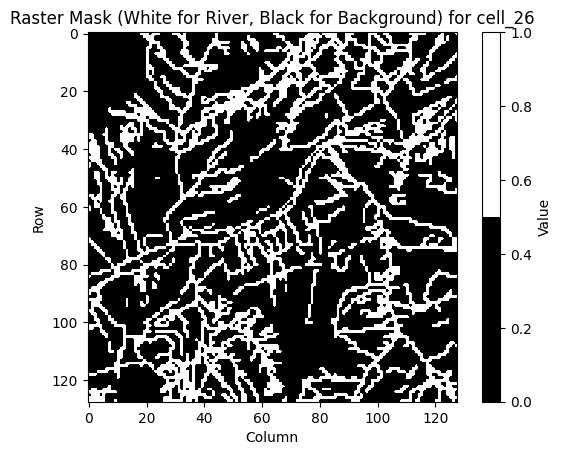

4696
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_26.tif with bounds 7.267327276366853, 46.15644307150512, 7.447689076287486, 46.2816973137518, EPSG:4326
Bounds for cell_49: [2704369.20868077 1085179.01944634 2716545.59556663 1099107.89709724]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_49


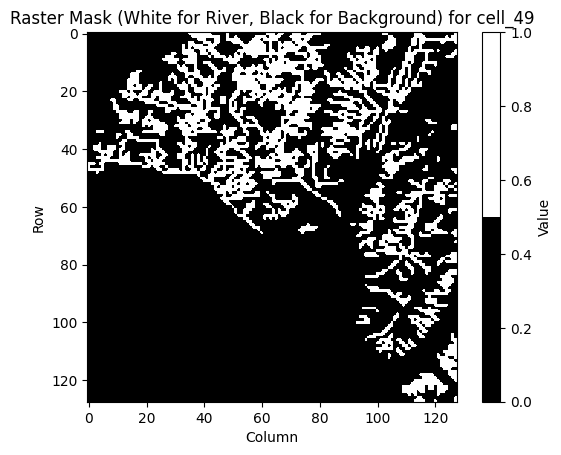

3216
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_49.tif with bounds 8.785590482620218, 45.908182003496044, 8.943955157427645, 46.03489187131081, EPSG:4326
Bounds for cell_5: [2616651.45436237 1193461.95629029 2630580.65454428 1207391.1501614 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_5


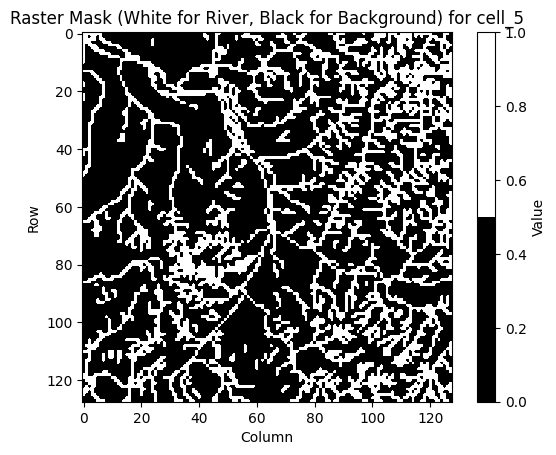

4968
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_5.tif with bounds 7.657140025410974, 46.89157960660956, 7.84080201217305, 47.017355373203614, EPSG:4326
Bounds for cell_27: [2779248.47547652 1176394.81334505 2793199.63707439 1190345.9685332 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_27


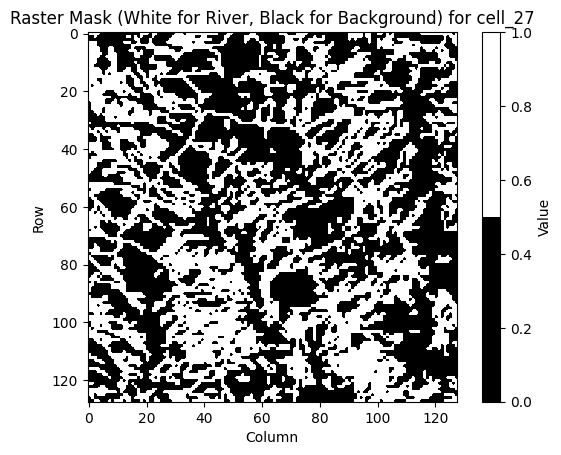

7247
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_27.tif with bounds 9.783466504704476, 46.71077483993116, 9.971510420273036, 46.840080455127186, EPSG:4326
Bounds for cell_15: [2620217.91888805 1260874.49055314 2634160.0566762  1270997.99016125]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_15


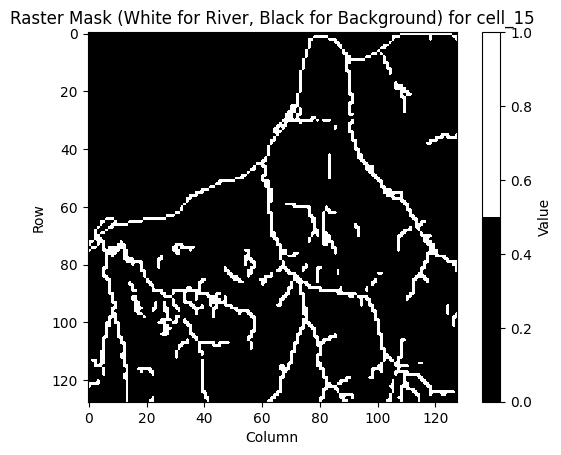

1426
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_15.tif with bounds 7.706963075002141, 47.49784912474883, 7.8927349321097715, 47.58887167399301, EPSG:4326
Bounds for cell_44: [2701081.93871245 1116990.28241733 2715014.3057222  1130922.64303942]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_44


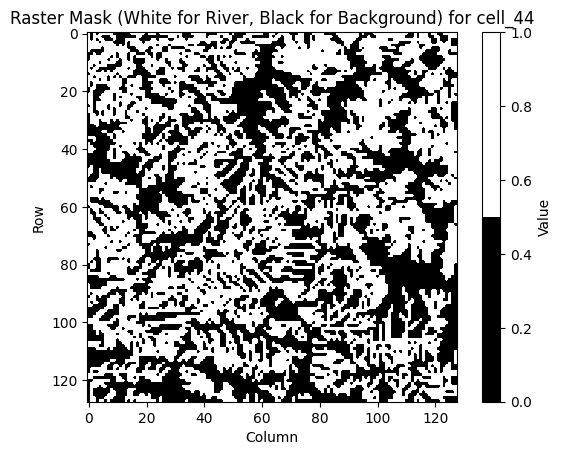

8819
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_44.tif with bounds 8.74832985727049, 46.194628765576695, 8.931999787831714, 46.32208701330393, EPSG:4326
Bounds for cell_50: [2746155.13561915 1254552.58819931 2760112.82825882 1268510.27446254]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_50


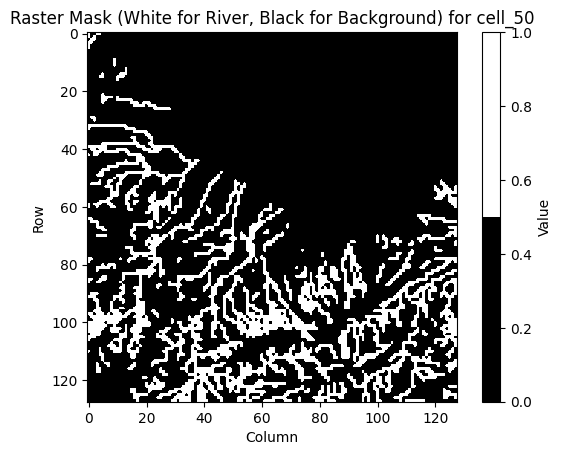

3001
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_50.tif with bounds 9.376492781113408, 47.42263600355137, 9.56363095881865, 47.551032985507426, EPSG:4326
Bounds for cell_76: [2492945.66226981 1110906.1857371  2506834.6306747  1124795.14787344]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_76


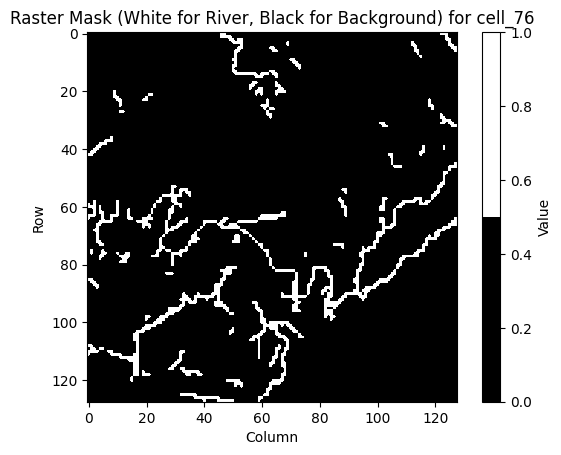

1061
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_76.tif with bounds 6.051348709965129, 46.14195999975994, 6.231542670468918, 46.268029641102096, EPSG:4326
Bounds for cell_55: [2626177.33385829 1161228.79249627 2640102.83675503 1175154.2890641 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_55


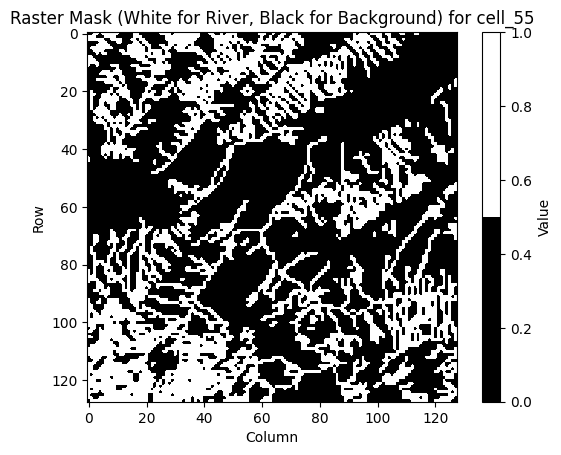

5712
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_55.tif with bounds 7.780322890769129, 46.60114246319566, 7.963021370722588, 46.72706327394208, EPSG:4326
Bounds for cell_40: [2707121.45693021 1254751.94459845 2721074.51403072 1268704.99534621]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_40


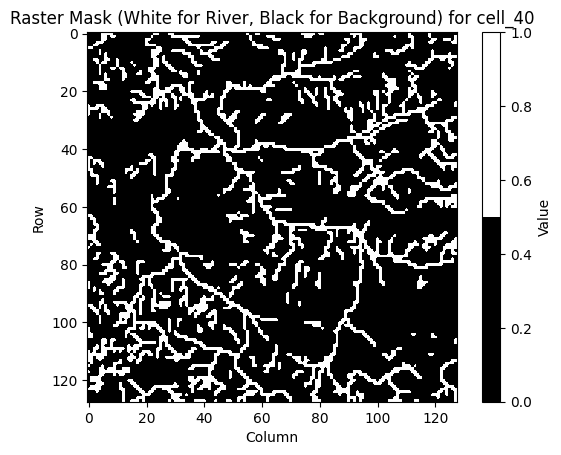

3167
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_40.tif with bounds 8.858761782897679, 47.432582911829606, 9.047325583295919, 47.55996682988472, EPSG:4326
Bounds for cell_79: [2651588.03379717 1211283.52384687 2665526.03350718 1225221.51722911]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_79


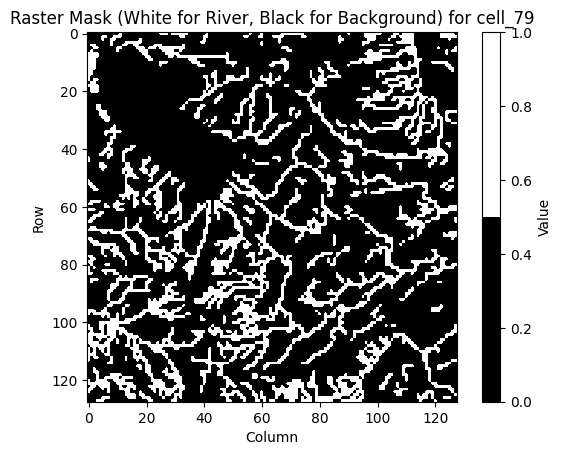

3928
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_79.tif with bounds 8.117609001745745, 47.0494283241901, 8.302980453200338, 47.17584278647919, EPSG:4326
Bounds for cell_66: [2702563.07383802 1262703.57421836 2716516.88227804 1276657.3763121 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_66


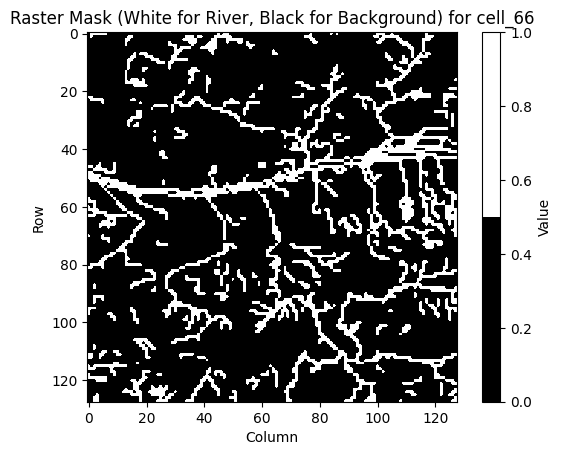

2879
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_66.tif with bounds 8.800389617463788, 47.50475360363888, 8.98842865514357, 47.63251441883009, EPSG:4326
Bounds for cell_16: [2642977.11362715 1170409.56716327 2656907.03584    1184339.48304016]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_16


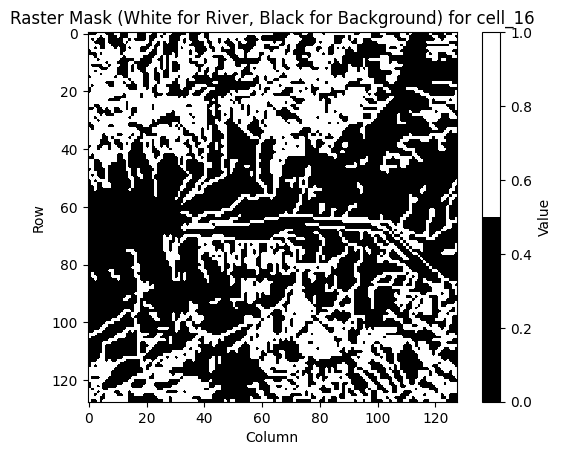

6503
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_16.tif with bounds 8.000397564898577, 46.682533392815394, 8.184187805735426, 46.80876236404322, EPSG:4326
Bounds for cell_13: [2666588.12963624 1195891.58963182 2680525.96523045 1209829.41888503]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_13


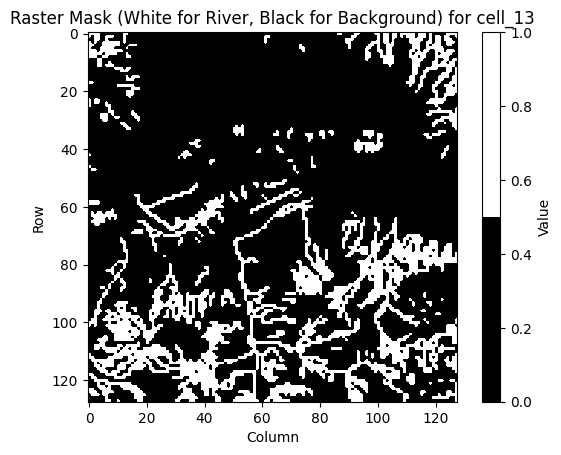

3420
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_13.tif with bounds 8.312754577434331, 46.909256621567, 8.498087883592262, 47.03614388334702, EPSG:4326
Bounds for cell_69: [2759326.22690692 1243392.65555311 2768745.72568098 1257350.17882128]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_69


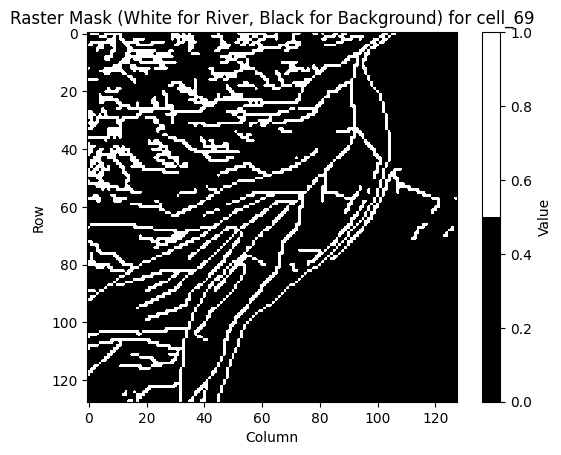

2646
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_69.tif with bounds 9.546751985257144, 47.321337715998396, 9.673811372221, 47.447570508807296, EPSG:4326
Bounds for cell_67: [2494267.76102178 1110715.81212735 2508156.53702097 1122068.05013075]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_67


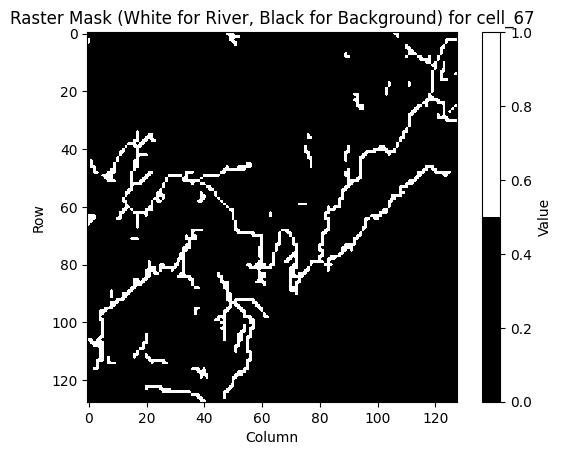

1041
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_67.tif with bounds 6.067828460690289, 46.14028424011445, 6.248358198918268, 46.24343263506656, EPSG:4326
Bounds for cell_74: [2683113.59539742 1186264.03019354 2697052.51541201 1200202.94385265]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_74


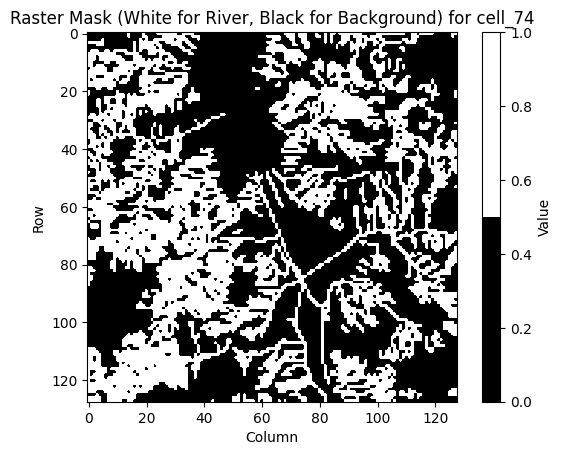

6763
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_74.tif with bounds 8.52786451144257, 46.82078963039395, 8.712990920183184, 46.94751645614655, EPSG:4326
Bounds for cell_48: [2720126.80592503 1240319.26628607 2734079.19109715 1254271.64509582]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_48


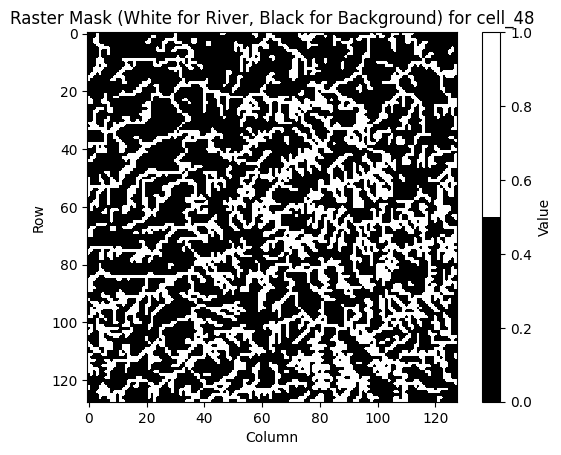

5653
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_48.tif with bounds 9.027290826173925, 47.30026353613972, 9.21535387704692, 47.42820391614883, EPSG:4326
Bounds for cell_53: [2606273.2149618  1172317.70332937 2620196.93744983 1186241.41950438]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_53


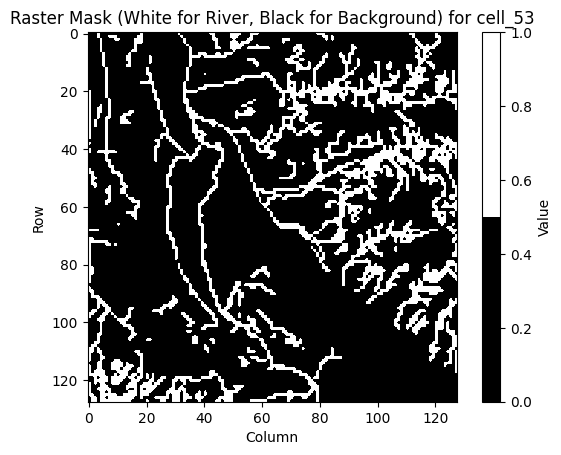

3210
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_53.tif with bounds 7.520665292709111, 46.701905467903806, 7.703235719534087, 46.827287872516955, EPSG:4326
Bounds for cell_75: [2671071.11237074 1262741.64085604 2685020.84972746 1276691.37188664]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_75


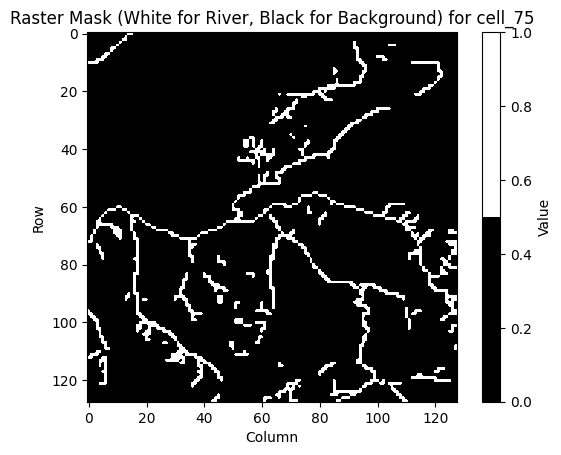

1240
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_75.tif with bounds 8.382647197674322, 47.510167798454106, 8.568478807345741, 47.63684844541995, EPSG:4326
Bounds for cell_3: [2622167.86925912 1133959.30208198 2636088.35577355 1147879.7822594 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_3


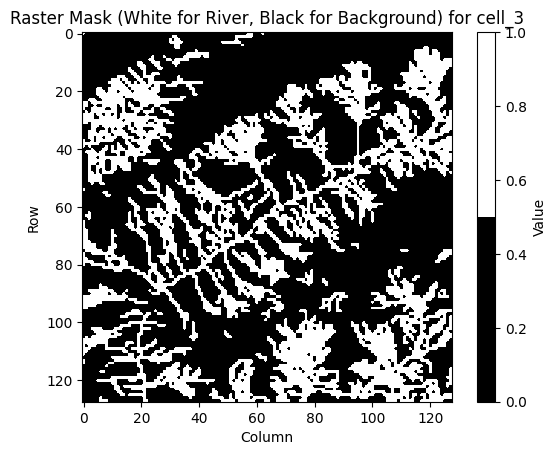

5347
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_3.tif with bounds 7.72673010095907, 46.356076579568395, 7.908510619753035, 46.481873968778075, EPSG:4326
Bounds for cell_70: [2678017.14451065 1128989.52190589 2691947.08034025 1142919.45136744]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_70


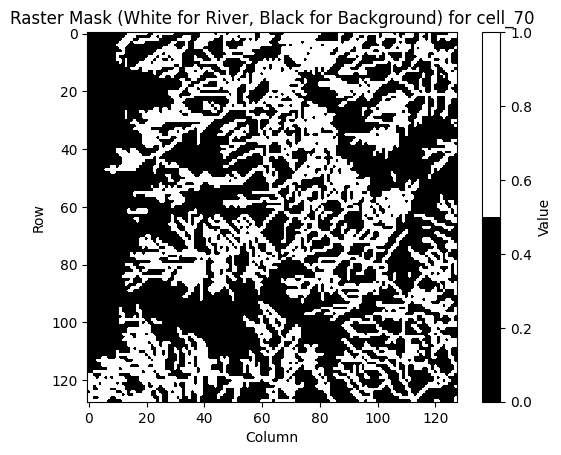

6422
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_70.tif with bounds 8.451392729436328, 46.306023817938524, 8.634930151610291, 46.43287141066331, EPSG:4326
Bounds for cell_54: [2795138.70844898 1135037.98705624 2809087.48323993 1148986.75542166]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_54


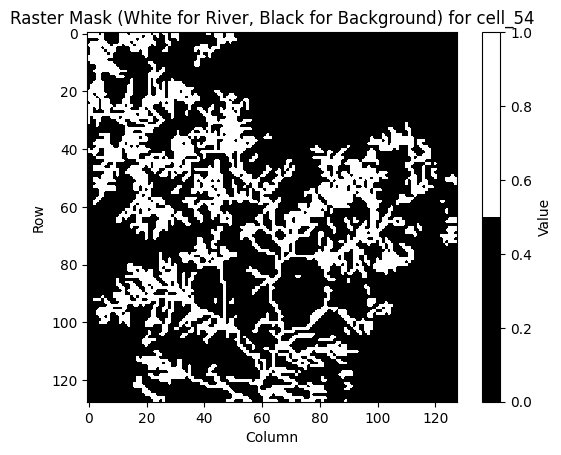

4115
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_54.tif with bounds 9.977476891688092, 46.33545674921081, 10.158362054799435, 46.463757367464346, EPSG:4326
Bounds for cell_30: [2606601.43474565 1256115.01334075 2620540.55279754 1270054.12510998]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_30


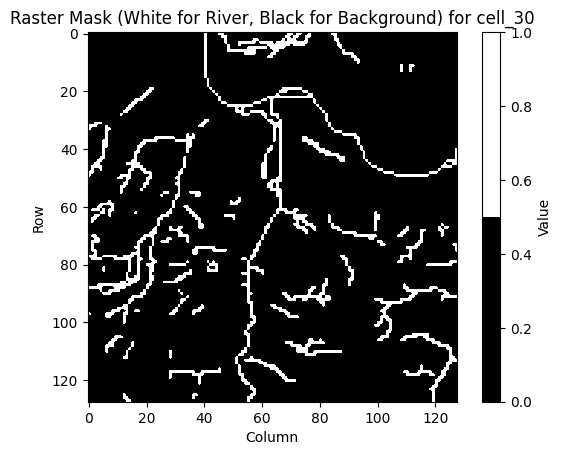

1448
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_30.tif with bounds 7.526212032371894, 47.45552835952321, 7.711443467667698, 47.581093181363435, EPSG:4326
Bounds for cell_2: [2726589.14819697 1111194.46268115 2739598.6007008  1125130.41122918]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_2


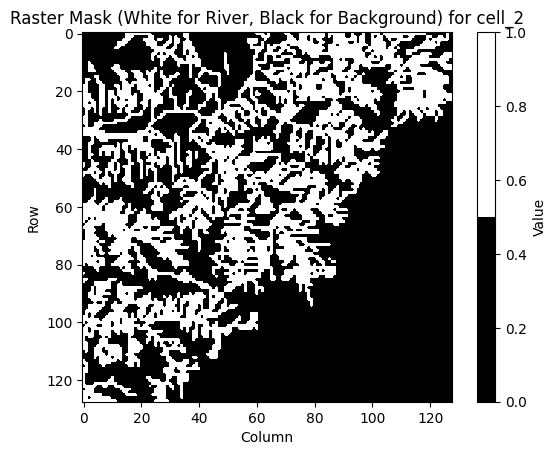

5564
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_2.tif with bounds 9.07692352447075, 46.13977296861492, 9.248797639204946, 46.26534999598946, EPSG:4326
Bounds for cell_52: [2658366.04522477 1204823.52223524 2672304.03354973 1218761.50422635]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_52


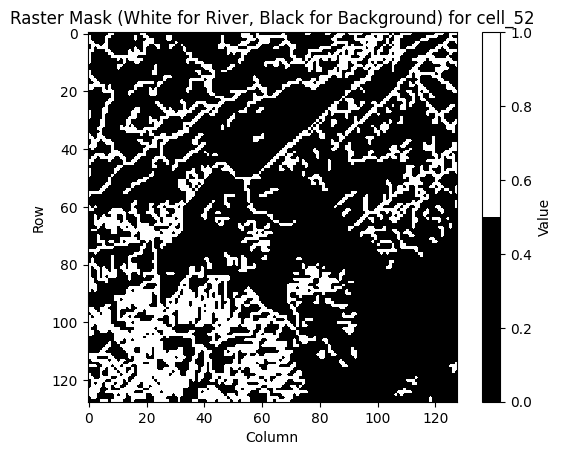

4439
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_52.tif with bounds 8.205998956540387, 46.991212305791684, 8.391362218038234, 47.11719475456272, EPSG:4326
Bounds for cell_51: [2656729.01830596 1206687.49879385 2670667.05709924 1220625.53125496]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_51


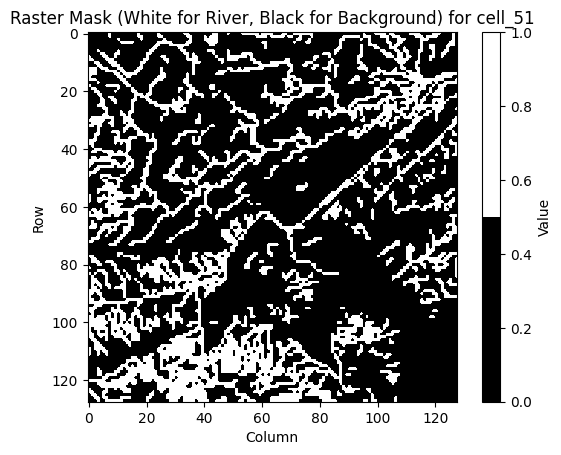

4539
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_51.tif with bounds 8.18470098323858, 47.00772061690854, 8.369844544989245, 47.133951937059095, EPSG:4326
Bounds for cell_81: [2636732.77369296 1130330.18956211 2650655.45589005 1144252.86541166]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_81


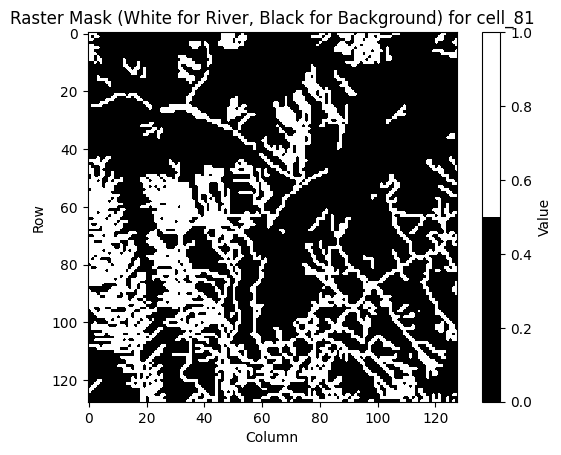

4789
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_81.tif with bounds 7.9156229818207136, 46.32247533862918, 8.097848172628666, 46.44860465332238, EPSG:4326
Bounds for cell_62: [2717011.26221401 1210993.69349848 2730958.79340577 1224941.218323  ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_62


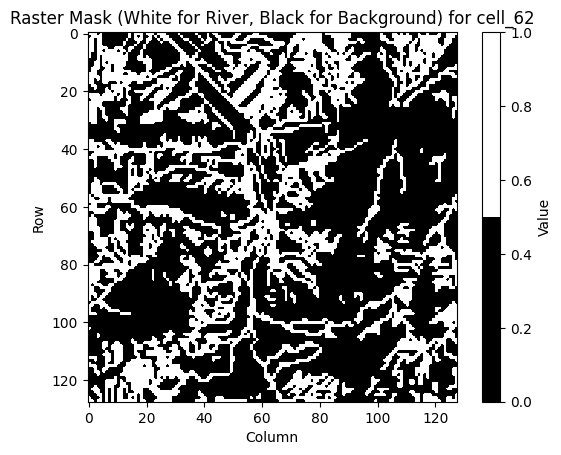

5609
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_62.tif with bounds 8.978356199850882, 47.03707716527338, 9.165507305767568, 47.16503901975482, EPSG:4326
Bounds for cell_34: [2823822.5376251  1161728.81942877 2833363.68575632 1175683.87115827]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_34


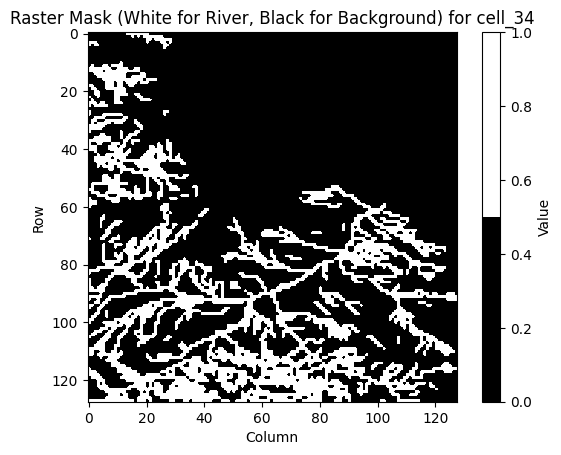

3728
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_34.tif with bounds 10.3587303883521, 46.56643340064862, 10.485034713877544, 46.694465452943994, EPSG:4326
Bounds for cell_39: [2513772.46836378 1143997.55109069 2527583.65850806 1154359.29341959]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_39


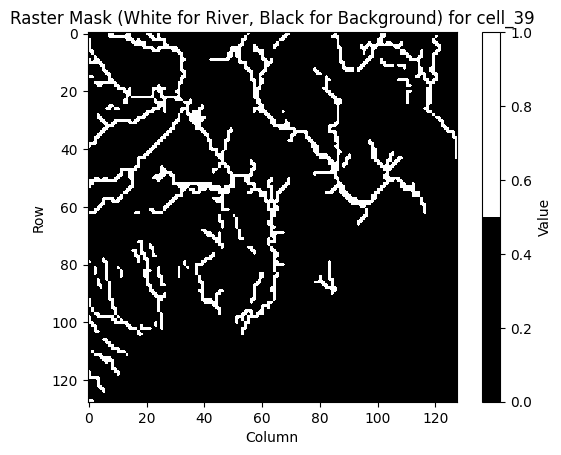

1584
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_39.tif with bounds 6.3146517996909655, 46.441755338169, 6.495143788634005, 46.53628770007554, EPSG:4326
Bounds for cell_29: [2662892.17829379 1147112.58883856 2676822.01349886 1161042.4176876 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_29


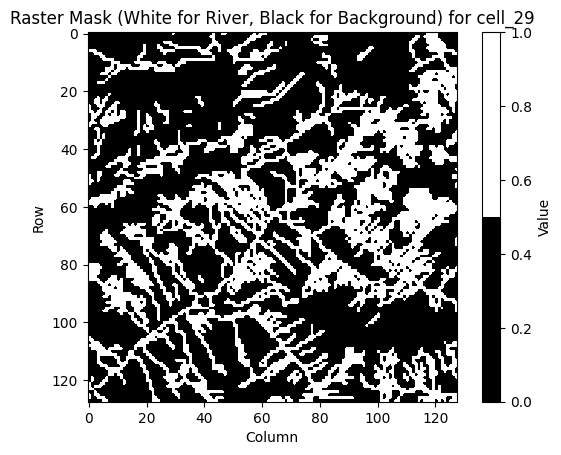

5477
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_29.tif with bounds 8.257534963030858, 46.47095273304512, 8.440949633443148, 46.59737556694641, EPSG:4326
Bounds for cell_47: [2572859.79538453 1220381.36530098 2586786.26877253 1234263.58316393]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_47


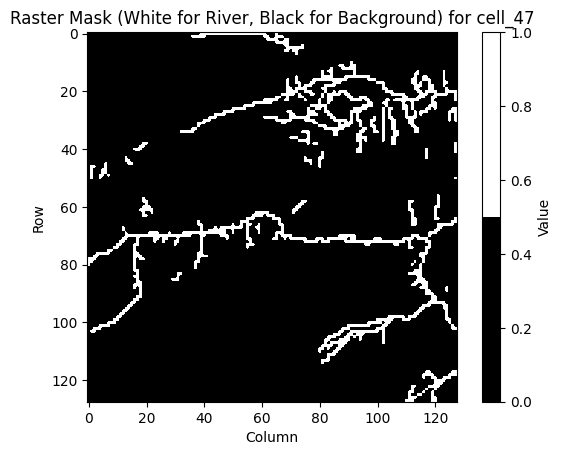

1235
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_47.tif with bounds 7.080572720669483, 47.13423916087928, 7.264425385201292, 47.25892049019603, EPSG:4326
Bounds for cell_4: [2728026.04312307 1175063.42553965 2741970.08153694 1189007.45757055]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_4


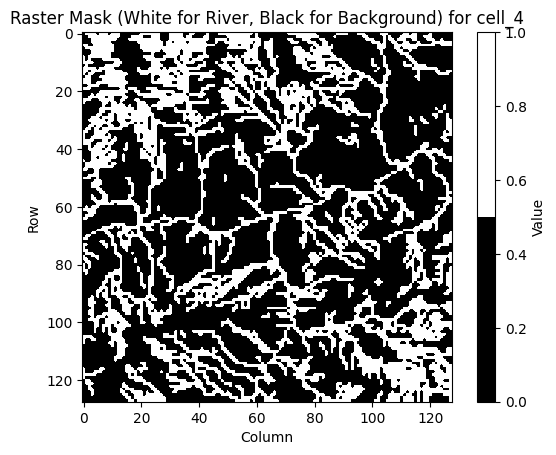

5607
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_4.tif with bounds 9.113439526927385, 46.711889571446484, 9.29967279340693, 46.8398379673368, EPSG:4326
Bounds for cell_22: [2573713.24708501 1204688.79932467 2587636.84771512 1218612.39367594]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_22


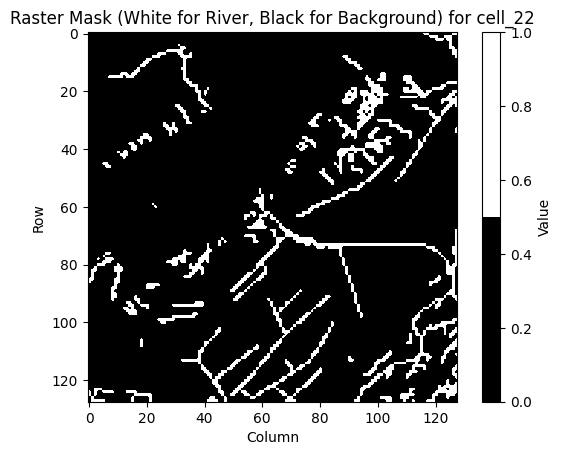

1525
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_22.tif with bounds 7.092796319045959, 46.9927409002982, 7.276081337593209, 47.11838394585587, EPSG:4326
Bounds for cell_77: [2604761.65587151 1265346.24608976 2618702.31387228 1271770.71216631]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_77


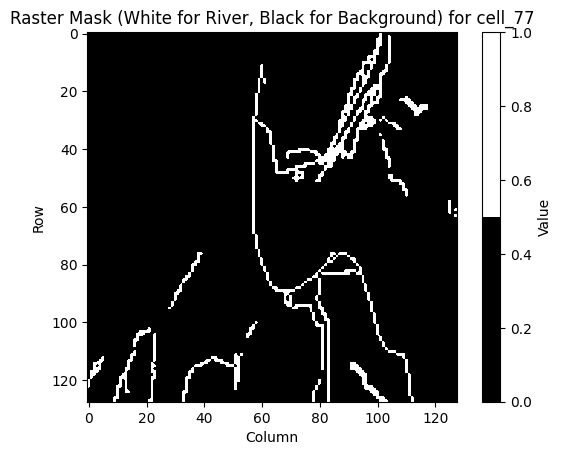

887
128 128 128 128
Raster saved to ../data/external/raster_masks/raster_mask_bw_cell_77.tif with bounds 7.501867149329284, 47.538623917298224, 7.68715587945476, 47.59643338901144, EPSG:4326


In [155]:
os.makedirs('../data/external/raster_masks/', exist_ok=True)
clear_directory('../data/external/raster_masks/')
# Desired output size
output_shape = (128, 128)
binary_masks = []
for k, river in river_cells.items():
    river_original = river.to_crs('EPSG:2056')

    # Check the bounds of the filtered river geometries
    x_min, y_min, x_max, y_max = list(river_original.total_bounds)
    print(f"Bounds for {k}: {river_original.total_bounds}")
    
    # Create the transform for 256x256 grid based on the bounds
    grid_width = output_shape[1]  # 256 pixels for width
    grid_height = output_shape[0]  # 256 pixels for height
    x_res = (x_max - x_min) / grid_width
    y_res = (y_max - y_min) / grid_height

    transform = from_origin(x_min, y_max, x_res, y_res)

    # Convert the LineStrings to a list of geometries for rasterization
    line_geometries = river_original.geometry.values

    # Create a raster mask for the output shape (256x256)
    out_shape = output_shape
    raster_array = np.zeros(out_shape)

    # Rasterize each LineString into the grid
    for i, geom in enumerate(line_geometries):
        if geom.is_empty:
            print(f"Empty geometry for {k}, skipping.")
            continue
        shape = (geom, 1)  # Assign a value of 1 for each line
        temp_mask = rasterize([shape], out_shape=out_shape, transform=transform)
        raster_array += temp_mask

    # Binarize the raster
    binary_mask = np.where(raster_array > 0.0, 1.0, 0.0)
    print(f"Min value: {binary_mask.min()}")
    print(f"Max value: {binary_mask.max()}")
    print('shape:', binary_mask.shape)
    binary_masks.append(binary_mask)
    print('done', k)

    # Define a colormap (black for background, white for river)
    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
    
    # Display the rasterized mask with a custom colormap
    plt.imshow(binary_mask, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title(f'Raster Mask (White for River, Black for Background) for {k}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()
    print(len(np.nonzero(binary_mask.reshape(-1))[0]))

    # Save the raster
    save_raster(raster_array, f'../data/external/raster_masks/raster_mask_bw_{k}.tif', river)


In [16]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
raster_metas = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks[cc]=rast
    river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
    river_mask_expanded = np.repeat(river_mask_expanded, total_data['lst'].shape[-1], axis=-1)  # Expande a (height, width, 3)
    river_masks_expanded[cc] = river_mask_expanded
    raster_metas[cc]=meta
    

(128, 128)


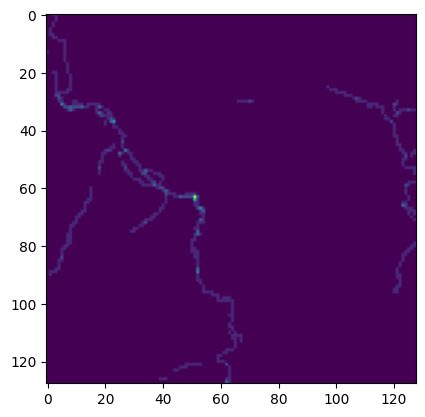

In [17]:
plt.imshow(river_masks['cell_73'])
print(river_masks['cell_73'].shape)

### LST and NDVI dataset

In [18]:
from collections import Counter
imgs_per_river = Counter(labels) 

In [21]:
imgs_per_river['cell_1']

8

In [22]:
import os
import numpy as np
import pandas as pd
from rasterio.features import rasterize

def process_river_data(total_data, total_times, river_masks, imgs_per_river, data_type, output_subdir, source_path='../data/preprocessed/'):
    """
    Process LST or NDVI data for rivers and save it as CSV files.

    Parameters:
        total_data (dict): Dictionary containing the image data (LST or NDVI).
        total_times (dict): Dictionary containing the timestamps for each image.
        river_masks (dict): Dictionary containing the river masks for each cell.
        imgs_per_river (dict): Dictionary with the number of images per river.
        data_type (str): Type of data to process ('lst' or 'ndvi').
        output_subdir (str): Subdirectory for saving CSV files (e.g., 'lst' or 'ndvi').
        source_path (str): Base directory for saving the output.
    """
    last = 0  # Track the starting index for each river
    for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
        print(f"Processing cell {cell} ({i + 1} of {len(imgs_per_river)})...",im_per_river)
        try:
            # Get the river mask and indices
            river_mask = river_masks[cell]
            cell_gdf = river_cells[cell]
            x_min, y_min, x_max, y_max = cell_gdf.total_bounds
            target_width, target_height = 128, 128
            transform = from_bounds(x_min, y_min, x_max, y_max, target_width, target_height)
        
            array = rasterize(
                [(geom, 1) for geom in cell_gdf.geometry],
                out_shape=(target_height, target_width),
                transform=transform,
                fill=0,  # Valor para áreas fuera de las geometrías
                dtype="float32"
            )
            river_indices = np.nonzero(array.reshape(-1))[0]

            # Initialize a DataFrame to store pixel values for this cell
            pixel_ds = pd.DataFrame(columns=river_indices)

            # Process images for this river cell
            for count in range(im_per_river):
                ind = count + last
                image = total_data[data_type][ind]

                # Flatten image and extract river pixel values
                if data_type == 'lst':  # Convert LST RGB to grayscale if needed
                    img_gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
                    flat_image = img_gray.flatten()
                else:  # NDVI doesn't need conversion
                    flat_image = image.flatten()

                river_image = flat_image[river_indices]
                pixel_ds.loc[total_times[data_type][ind]] = river_image

            # Update the starting index for the next river
            last += im_per_river

            # Save to CSV
            csv_dir = f"{source_path}{output_subdir}/{cell}/"
            os.makedirs(csv_dir, exist_ok=True)
            csv_path = f"{csv_dir}{cell}.csv"
            if os.path.exists(csv_path):
                os.remove(csv_path)
            pixel_ds.to_csv(csv_path)
            print(f"Saved: {csv_path}")

        except KeyError as e:
            print(f"KeyError for cell {cell}: {e}")
            continue


In [25]:
# Process LST data
process_river_data(
    total_data=total_data,
    total_times=total_times,
    river_masks=river_cells,  # Or river_masks if available
    imgs_per_river=imgs_per_river,
    data_type='lst',
    output_subdir='lst'
)

# Process NDVI data
process_river_data(
    total_data=total_data,
    total_times=total_times,
    river_masks=river_cells,
    imgs_per_river=imgs_per_river,
    data_type='ndvi',
    output_subdir='ndvi'
)


Processing cell cell_67 (1 of 74)... 13
Saved: ../data/preprocessed/lst/cell_67/cell_67.csv
Processing cell cell_2 (2 of 74)... 15
Saved: ../data/preprocessed/lst/cell_2/cell_2.csv
Processing cell cell_31 (3 of 74)... 17
Saved: ../data/preprocessed/lst/cell_31/cell_31.csv
Processing cell cell_19 (4 of 74)... 19
Saved: ../data/preprocessed/lst/cell_19/cell_19.csv
Processing cell cell_29 (5 of 74)... 20
Saved: ../data/preprocessed/lst/cell_29/cell_29.csv
Processing cell cell_71 (6 of 74)... 34
Saved: ../data/preprocessed/lst/cell_71/cell_71.csv
Processing cell cell_49 (7 of 74)... 9
Saved: ../data/preprocessed/lst/cell_49/cell_49.csv
Processing cell cell_43 (8 of 74)... 15
Saved: ../data/preprocessed/lst/cell_43/cell_43.csv
Processing cell cell_10 (9 of 74)... 13
Saved: ../data/preprocessed/lst/cell_10/cell_10.csv
Processing cell cell_13 (10 of 74)... 26
Saved: ../data/preprocessed/lst/cell_13/cell_13.csv
Processing cell cell_41 (11 of 74)... 16
Saved: ../data/preprocessed/lst/cell_41/ce

# Normalize, partition and save data

In [30]:
def load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths=['lst', 'slope', 'discharge', 'ndvi', 'altitude'],
    filter_altitude=None,
    W=256,
    time_split=False,
):
    
    dir_paths = [os.path.join(source_path, p) for p in data_paths]
    
    all_dir_paths = {k: [] for k in data_paths}
    total_data = {}
    total_times = {}

    rivers = get_rivers_altitude(source_folder,filter_altitude)[0]
    
    # Cargar rutas de entrada
    for i, dir_p in enumerate(dir_paths):
        for subdir, dirs, files in os.walk(dir_p):
            if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
                all_dir_paths[data_paths[i]].append(subdir)
            elif dir_p.endswith('altitude'):
                all_dir_paths[data_paths[i]].extend([f for f in files if f.split('.')[0] in rivers])
      
    # Cargar datos de entrada
    
    for k, v in all_dir_paths.items():
        if k not in ['direction', 'slope', 'altitude']:
            labels = []
            list_rgb = [True] * len(v) if k in ['lst', 'masked'] else [False] * len(v)
            data, times = load_data(v, W, list_rgb)
            if k != 'masked':
                for ki in data.keys():
                    labels += [ki.split('/')[-1]] * len(data[ki])

            data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
            times_list = [t for sublist in times for t in sublist]

            if time_split:
                dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
                pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
                sorted_dates, data_values, labels = zip(*pairs)
                times_list = [date.strftime('%Y-%m') for date in sorted_dates]

            total_data[k] = np.array(data_values)
            total_times[k] = times_list
            print(f"{k} : {total_data[k].shape}")

    origin_folder = source_path.split(f'{W}x{W}')[0]
    print(origin_folder,'ole')
    # Cargar variables adicionales
    for k, v in all_dir_paths.items():
        if k in ['direction', 'slope', 'altitude']:
            imgss = {}
            total = []
            for i, lab in enumerate(labels):
                for file in v:
                    if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                        if lab not in imgss:
                            file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join(f'{origin_folder}altitude', file)
                            r, m = load_raster(file_path, False)
                            var = resize_image(r, W, W)
                            var = np.where(np.isnan(var), 0.0, var)
                            imgss[lab] = var
                        else:
                            var = imgss[lab]
                            
                total.append(var)

            total_data[k] = np.array(total)
            print(f"{k}: {np.array(total).shape}")

    # Cargar variable objetivo
    water_temp = pd.read_csv(f'{origin_folder}wt/water_temp.csv', index_col=0)
    times_ordered = total_times['lst']
    wt_temp = []
    for cell, date in zip(labels, times_ordered):
        temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
        if not temp.empty:
            wt_temp.append(temp.values[0])
    data_targets = np.array(wt_temp)

    return total_data, total_times, data_targets, labels

In [53]:
inputs = ['lst','ndvi','slope', 'altitude', 'direction']
split = 'random'
W = 64

data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/64x64/',
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

total_data, total_times, data_targets, labels = data

lst : (1307, 64, 64, 3)
ndvi : (1307, 64, 64)
../data/preprocessed/ ole
slope: (1307, 64, 64)
altitude: (1307, 64, 64)
direction: (1307, 64, 64)


In [54]:
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
lat, lon = get_lat_lon(labels)
discharge = get_discharge(labels, total_times['lst'])
additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))

# Normalize images
total_data['lst'] = total_data['lst'][..., 0]

expanded_images = []
for inp in inputs:
    all_images = total_data[inp]  # Load all images for the current input
    mean_val = np.mean(all_images)  # Compute the mean
    std_val = np.std(all_images)  # Compute the standard deviation
    
    # Handle the edge case where standard deviation is zero
    if std_val == 0:
        print(f"Warning: Standard deviation for {inp} is zero. Skipping normalization.")
        normalized_images = all_images  # Leave the data unchanged
    else:
        normalized_images = (all_images - mean_val) / std_val  # Z-score normalization
    
    # Expand dimensions if necessary
    if normalized_images.ndim == 3:
        normalized_images = np.expand_dims(normalized_images, axis=-1)
    
    expanded_images.append(normalized_images)

# Combine all normalized images
combined_input = np.concatenate(expanded_images, axis=-1)
input_data = combined_input
print('Shape', input_data.shape)

Shape (1307, 64, 64, 5)


In [55]:
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
lat, lon = get_lat_lon(labels)
discharge = get_discharge(labels, total_times['lst'])
additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))

In [56]:
inputs = ['lst','ndvi','slope', 'altitude', 'direction']
for W in [8, 16, 32, 64,128]:
    if W == 128:
        source_path=f'../data/preprocessed/'
    else:
        source_path=f'../data/preprocessed/{W}x{W}/'
        
    data = load_all_data(
        source_folder='../data/external/shp/river_cells_oficial',
        source_path=source_path,
        data_paths= inputs,
        filter_altitude=False,
        W=W,
        time_split=True if split=='time' else False)

    total_data, total_times, data_targets, labels = data

    cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
    lat, lon = get_lat_lon(labels)
    discharge = get_discharge(labels, total_times['lst'])
    additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))
    total_data['lst'] = total_data['lst'][..., 0]

    expanded_images = []
    for inp in inputs:
        all_images = total_data[inp]  # Load all images for the current input
        mean_val = np.mean(all_images)  # Compute the mean
        std_val = np.std(all_images)  # Compute the standard deviation
        
        # Handle the edge case where standard deviation is zero
        if std_val == 0:
            print(f"Warning: Standard deviation for {inp} is zero. Skipping normalization.")
            normalized_images = all_images  # Leave the data unchanged
        else:
            normalized_images = (all_images - mean_val) / std_val  # Z-score normalization
        
        # Expand dimensions if necessary
        if normalized_images.ndim == 3:
            normalized_images = np.expand_dims(normalized_images, axis=-1)
        
        expanded_images.append(normalized_images)
    
    # Combine all normalized images
    combined_input = np.concatenate(expanded_images, axis=-1)
    input_data = combined_input
    
    for split in range(1,6):
        # Split data into train, validation, and test
        train_index, validation_index, test_index = get_split_index('stratified', input_data, data_targets, labels, split, False)
        
        train_input = input_data[train_index, :]
        train_target = data_targets[train_index]
        additional_inputs_train = additional_inputs[train_index, :]
        
        validation_input = input_data[validation_index, :]
        validation_target = data_targets[validation_index]
        additional_inputs_validation = additional_inputs[validation_index, :]
    
        test_input = input_data[test_index, :]
        test_target = data_targets[test_index]
        additional_inputs_test = additional_inputs[test_index, :]
    
        # Save the processed data into specific folders
        # ---------------------------------------------
        
        # Define output directories
        output_dir = f'../data/processed_data/{W}x{W}/{split}'
        os.makedirs(output_dir, exist_ok=True)
        
        train_dir = os.path.join(output_dir, 'train')
        validation_dir = os.path.join(output_dir, 'validation')
        test_dir = os.path.join(output_dir, 'test')
        
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(validation_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        
        # Save processed data for each split
        np.save(os.path.join(train_dir, 'input_data.npy'), train_input)
        np.save(os.path.join(train_dir, 'target_data.npy'), train_target)
        np.save(os.path.join(train_dir, 'additional_inputs.npy'), additional_inputs_train)
        
        np.save(os.path.join(validation_dir, 'input_data.npy'), validation_input)
        np.save(os.path.join(validation_dir, 'target_data.npy'), validation_target)
        np.save(os.path.join(validation_dir, 'additional_inputs.npy'), additional_inputs_validation)
        
        np.save(os.path.join(test_dir, 'input_data.npy'), test_input)
        np.save(os.path.join(test_dir, 'target_data.npy'), test_target)
        np.save(os.path.join(test_dir, 'additional_inputs.npy'), additional_inputs_test)
        
        print(f"Data saved successfully at {output_dir}.")

lst : (1307, 8, 8, 3)
ndvi : (1307, 8, 8)
../data/preprocessed/ ole
slope: (1307, 8, 8)
altitude: (1307, 8, 8)
direction: (1307, 8, 8)
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/8x8/1.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/8x8/2.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/8x8/3.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/8x8/4.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/8x8/5.
lst : (1307, 16, 16, 3)
ndvi : (1307, 16, 16)
../data/preprocessed/ ole
slope: (1307, 16, 16)
altitude: (1307, 16, 16)
direction: (1307, 16, 16)
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/16x16/1.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/16x16/2.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/16x16/3.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data/16x16/4.
yes !!!!!!!!!!
Data saved successfully at ../data/processed_data

In [57]:
W=128
data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path=f'../data/preprocessed/',
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

total_data, total_times, data_targets, labels = data

cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
lat, lon = get_lat_lon(labels)
discharge = get_discharge(labels, total_times['lst'])
additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))
total_data['lst'] = total_data['lst'][..., 0]

expanded_images = []
for inp in inputs:
    all_images = total_data[inp]  # Load all images for the current input
    mean_val = np.mean(all_images)  # Compute the mean
    std_val = np.std(all_images)  # Compute the standard deviation
    
    # Handle the edge case where standard deviation is zero
    if std_val == 0:
        print(f"Warning: Standard deviation for {inp} is zero. Skipping normalization.")
        normalized_images = all_images  # Leave the data unchanged
    else:
        normalized_images = (all_images - mean_val) / std_val  # Z-score normalization
    
    # Expand dimensions if necessary
    if normalized_images.ndim == 3:
        normalized_images = np.expand_dims(normalized_images, axis=-1)
    
    expanded_images.append(normalized_images)

# Combine all normalized images
combined_input = np.concatenate(expanded_images, axis=-1)
input_data = combined_input

for split in range(1,6):
    # Split data into train, validation, and test
    train_index, validation_index, test_index = get_split_index('stratified', input_data, data_targets, labels, split, False)
    
    train_input = input_data[train_index, :]
    train_target = data_targets[train_index]
    additional_inputs_train = additional_inputs[train_index, :]
    
    validation_input = input_data[validation_index, :]
    validation_target = data_targets[validation_index]
    additional_inputs_validation = additional_inputs[validation_index, :]

    test_input = input_data[test_index, :]
    test_target = data_targets[test_index]
    additional_inputs_test = additional_inputs[test_index, :]

    # Save the processed data into specific folders
    # ---------------------------------------------
    
    # Define output directories
    output_dir = f'../data/processed_data/{W}x{W}/{split}'
    os.makedirs(output_dir, exist_ok=True)
    
    train_dir = os.path.join(output_dir, 'train')
    validation_dir = os.path.join(output_dir, 'validation')
    test_dir = os.path.join(output_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Save processed data for each split
    np.save(os.path.join(train_dir, 'input_data.npy'), train_input)
    np.save(os.path.join(train_dir, 'target_data.npy'), train_target)
    np.save(os.path.join(train_dir, 'additional_inputs.npy'), additional_inputs_train)
    
    np.save(os.path.join(validation_dir, 'input_data.npy'), validation_input)
    np.save(os.path.join(validation_dir, 'target_data.npy'), validation_target)
    np.save(os.path.join(validation_dir, 'additional_inputs.npy'), additional_inputs_validation)
    
    np.save(os.path.join(test_dir, 'input_data.npy'), test_input)
    np.save(os.path.join(test_dir, 'target_data.npy'), test_target)
    np.save(os.path.join(test_dir, 'additional_inputs.npy'), additional_inputs_test)
    
    print("Data saved successfully.")

lst : (1307, 128, 128, 3)
ndvi : (1307, 128, 128)
../data/preprocessed/ ole
slope: (1307, 128, 128)
altitude: (1307, 128, 128)
direction: (1307, 128, 128)
yes !!!!!!!!!!
Data saved successfully.
yes !!!!!!!!!!
Data saved successfully.
yes !!!!!!!!!!
Data saved successfully.
yes !!!!!!!!!!
Data saved successfully.
yes !!!!!!!!!!
Data saved successfully.


In [31]:
import pickle
with open('../data/external/cos_to_month.pkl', 'wb') as file:
    pickle.dump(cos_to_month, file)

### Check

In [58]:
for split in range(1,6):
    output_dir = f'../data/processed_data/64x64/{split}'
    train_dir = os.path.join(output_dir, 'train')
    validation_dir = os.path.join(output_dir, 'validation')
    test_dir = os.path.join(output_dir, 'test')
    
    # Load train data
    train_input = np.load(os.path.join(train_dir, 'input_data.npy'))
    train_target = np.load(os.path.join(train_dir, 'target_data.npy'))
    additional_inputs_train = np.load(os.path.join(train_dir, 'additional_inputs.npy'))
    
    # Load validation data
    validation_input = np.load(os.path.join(validation_dir, 'input_data.npy'))
    validation_target = np.load(os.path.join(validation_dir, 'target_data.npy'))
    additional_inputs_validation = np.load(os.path.join(validation_dir, 'additional_inputs.npy'))
    
    # Load test data
    test_input = np.load(os.path.join(test_dir, 'input_data.npy'))
    test_target = np.load(os.path.join(test_dir, 'target_data.npy'))
    additional_inputs_test = np.load(os.path.join(test_dir, 'additional_inputs.npy'))
    
    # Confirm successful loading
    print(f"Train input shape: {train_input.shape}, {additional_inputs_train.shape}")
    print(f"Validation input shape: {validation_input.shape}, {additional_inputs_validation.shape}")
    print(f"Test input shape: {test_input.shape}, {additional_inputs_test.shape}")
    
    print("Data loaded successfully.")


Train input shape: (784, 64, 64, 5), (784, 5)
Validation input shape: (261, 64, 64, 5), (261, 5)
Test input shape: (262, 64, 64, 5), (262, 5)
Data loaded successfully.
Train input shape: (784, 64, 64, 5), (784, 5)
Validation input shape: (261, 64, 64, 5), (261, 5)
Test input shape: (262, 64, 64, 5), (262, 5)
Data loaded successfully.
Train input shape: (784, 64, 64, 5), (784, 5)
Validation input shape: (261, 64, 64, 5), (261, 5)
Test input shape: (262, 64, 64, 5), (262, 5)
Data loaded successfully.
Train input shape: (784, 64, 64, 5), (784, 5)
Validation input shape: (261, 64, 64, 5), (261, 5)
Test input shape: (262, 64, 64, 5), (262, 5)
Data loaded successfully.
Train input shape: (784, 64, 64, 5), (784, 5)
Validation input shape: (261, 64, 64, 5), (261, 5)
Test input shape: (262, 64, 64, 5), (262, 5)
Data loaded successfully.


In [33]:
inputs += ['month', 'coords', 'discharge']
inputs

['lst',
 'ndvi',
 'slope',
 'altitude',
 'direction',
 'month',
 'coords',
 'discharge']

In [34]:
# Define the variables and their positions or channels
var_channels = {'lst': 0, 'ndvi': 1, 'slope': 2, 'altitude': 3, 'direction': 4}
var_position = {'month': [0, 1], 'coords': [2, 3], 'discharge': 4}

# Initialize inputs
train_image_inputs = []  # To store image-based inputs
train_vector_inputs = []  # To store vector-based inputs

val_image_inputs = []
val_vector_inputs = []

test_image_inputs = []
test_vector_inputs = []

# Build the inputs based on the variables in the list `inputs`
for inp in inputs:
    if inp in var_channels:
        # Add image channels
        channel = var_channels[inp]
        train_image_inputs.append(train_input[..., channel:channel + 1])  # Slicing to preserve dimensions
        val_image_inputs.append(validation_input[..., channel:channel + 1])
        test_image_inputs.append(test_input[..., channel:channel + 1])
    elif inp in var_position:
        # Add vector-based inputs from `additional_inputs`
        position = var_position[inp]
        if isinstance(position, list):
            train_vector_inputs.append(additional_inputs_train[:, position])
            val_vector_inputs.append(additional_inputs_validation[:, position])
            test_vector_inputs.append(additional_inputs_test[:, position])
        else:
            train_vector_inputs.append(additional_inputs_train[:, position:position + 1])
            val_vector_inputs.append(additional_inputs_validation[:, position:position + 1])
            test_vector_inputs.append(additional_inputs_test[:, position:position + 1])

# Combine image inputs along the last axis
train_image_inputs = np.concatenate(train_image_inputs, axis=-1) if train_image_inputs else None
val_image_inputs = np.concatenate(val_image_inputs, axis=-1) if val_image_inputs else None
test_image_inputs = np.concatenate(test_image_inputs, axis=-1) if test_image_inputs else None

# Combine vector inputs along the last axis
train_vector_inputs = np.concatenate(train_vector_inputs, axis=-1) if train_vector_inputs else None
val_vector_inputs = np.concatenate(val_vector_inputs, axis=-1) if val_vector_inputs else None
test_vector_inputs = np.concatenate(test_vector_inputs, axis=-1) if test_vector_inputs else None

# Adjust input_args and model_input format
if train_vector_inputs is not None:  # If vector inputs are present
    input_args = (train_image_inputs.shape[1:], train_vector_inputs.shape[1])
    train_model_input = [train_image_inputs, train_vector_inputs]
    val_model_input = [val_image_inputs, val_vector_inputs]
    test_model_input = [test_image_inputs, test_vector_inputs]
else:  # Only image inputs
    input_args = train_image_inputs.shape[1:]
    train_model_input = train_image_inputs
    val_model_input = val_image_inputs
    test_model_input = test_image_inputs

# Print shapes for verification
if isinstance(train_model_input, list):
    print(f"Train model input shapes: {[x.shape for x in train_model_input]}")
else:
    print(f"Train model input shape: {train_model_input.shape}")


Train model input shapes: [(803, 64, 64, 5), (803, 5)]


In [74]:
len(input_args)>1

True